In [3]:
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from transformers import GPT2TokenizerFast, GPT2LMHeadModel
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image
import torch.nn.functional as F
from tqdm import tqdm

In [2]:
import pandas as pd
    
# Caricamento dei file CSV
df_image = pd.read_csv('/kaggle/input/chest-xrays-indiana-university/indiana_projections.csv')
df_report = pd.read_csv('/kaggle/input/chest-xrays-indiana-university/indiana_reports.csv')

# Creazione di un DataFrame vuoto per le immagini frontale, laterale, didascalia e problemi
df = pd.DataFrame({'front_img': [], 'lateral_img': [], 'captions': [], 'problems': []})

# Ciclo attraverso ogni immagine nel DataFrame delle immagini
for uid in df_image['uid'].unique():
    # Trovo tutte le immagini per ogni 'uid'
    front_image = df_image.loc[(df_image['uid'] == uid) & (df_image['projection'] == 'Frontal')]
    lateral_img = df_image.loc[(df_image['uid'] == uid) & (df_image['projection'] == 'Lateral')]
    
    # Se ci sono sia immagini frontali che laterali
    if not front_image.empty and not lateral_img.empty:
        # Trovo la didascalia corrispondente
        caption = df_report.loc[df_report['uid'] == uid, 'findings'].values[0]
        # Trovo i problemi corrispondenti
        problems = df_report.loc[df_report['uid'] == uid, 'Problems'].values[0]
        
        # Aggiungo la riga al DataFrame
        df = pd.concat([df, pd.DataFrame([{
            'front_img': front_image.iloc[0]['filename'],
            'lateral_img': lateral_img.iloc[0]['filename'],
            'captions': caption,
            'problems': problems
        }])], axis=0)

# Aggiorno i percorsi delle immagini
loc = '/kaggle/input/chest-xrays-indiana-university/images/images_normalized/'
df['front_img'] = loc + df['front_img']
df['lateral_img'] = loc + df['lateral_img']

# Reset dell'indice per assicurarsi che sia unico
#cosi facendo ogni riga ha un id univoco
df = df.reset_index(drop=True)

# Mostra il risultato finale
print(df.head())

                                           front_img  \
0  /kaggle/input/chest-xrays-indiana-university/i...   
1  /kaggle/input/chest-xrays-indiana-university/i...   
2  /kaggle/input/chest-xrays-indiana-university/i...   
3  /kaggle/input/chest-xrays-indiana-university/i...   
4  /kaggle/input/chest-xrays-indiana-university/i...   

                                         lateral_img  \
0  /kaggle/input/chest-xrays-indiana-university/i...   
1  /kaggle/input/chest-xrays-indiana-university/i...   
2  /kaggle/input/chest-xrays-indiana-university/i...   
3  /kaggle/input/chest-xrays-indiana-university/i...   
4  /kaggle/input/chest-xrays-indiana-university/i...   

                                            captions  \
0  The cardiac silhouette and mediastinum size ar...   
1  Borderline cardiomegaly. Midline sternotomy XX...   
2                                                NaN   
3  There are diffuse bilateral interstitial and a...   
4  The cardiomediastinal silhouette and pulmon

In [4]:
import pandas as pd
normal_rows = df[df['problems'].str.contains('normal', na=False)]
print(f"Numero di righe con 'Normal': {len(normal_rows)}")
rows_to_remove = normal_rows.sample(frac=0.5, random_state=42).index

print(f"lunghezza df prima di drop: {len(df)}")
df = df.drop(rows_to_remove)
print(f"lunghezza prima df dopo drop: {len(df)}")

Numero di righe con 'Normal': 1244
lunghezza df prima di drop: 3388
lunghezza prima df dopo drop: 2766


In [5]:
# Calcola le occorrenze di ciascun problema
problem_counts = {}
for problems in df['problems'].dropna():
    for problem in problems.split(';'):
        problem = problem.strip()  # Rimuovi spazi extra
        problem_counts[problem] = problem_counts.get(problem, 0) + 1

# Definisci i problemi da eliminare
problems_to_delete = [
    "No Indexing",
    "Technical Quality of Image Unsatisfactory",
    "Foreign Bodies",
    "Calcinosis",
    "Density",
    "Diaphragm",
    "Diaphragmatic Eventration",
    "Hernia, Hiatal",
    "Catheters, Indwelling",
    "Surgical Instruments",
    "Implanted Medical Device",
    "Medical Device",
    "Lucency",
    "Tube, Inserted",
    "Markings",
]

# Funzione per filtrare i problemi di una riga
def filter_problems(problems, threshold=20):
    """
    Rimuove i problemi con occorrenze inferiori al valore di soglia.
    Rimuove anche il problema "No Indexing".
    Restituisce una stringa con i problemi filtrati o None se non ne rimane nessuno.
    """
    if not problems:  # Controlla se il campo è vuoto o NaN
        return None
    filtered_problems = [
        problem.strip() for problem in problems.split(';')
        if problem_counts.get(problem.strip(), 0) >= threshold and problem.strip() not in problems_to_delete
    ]
    return ';'.join(filtered_problems) if filtered_problems else None

# Applica il filtro ai problemi
df['problems'] = df['problems'].apply(filter_problems)

# Elimina le righe senza problemi rimanenti
df = df.dropna(subset=['problems']).reset_index(drop=True)

# Risultati
print(f"Dataset dopo la pulizia: {len(df)} righe rimanenti.")


Dataset dopo la pulizia: 2494 righe rimanenti.


In [6]:
import pandas as pd

def count_problems_occurrences(df):
    """
    Conta e stampa i problemi e il numero di occorrenze di ciascuno nel dataset.
    
    Args:
    df (pd.DataFrame): DataFrame contenente la colonna 'problems'.
    """
    # Controllo che la colonna 'problems' esista
    if 'problems' not in df.columns:
        print("La colonna 'problems' non è presente nel DataFrame.")
        return
    
    # Separare i problemi se sono multipli (ad esempio, separati da punto e virgola)
    all_problems = df['problems'].dropna().str.split(';')
    
    # Flatten della lista di problemi e conteggio delle occorrenze
    problem_counts = {}
    for problem_list in all_problems:
        for problem in problem_list:
            problem = problem.strip()  # Rimuovere eventuali spazi vuoti all'inizio o alla fine
            problem_counts[problem] = problem_counts.get(problem, 0) + 1
    
    # Ordinare i problemi per numero di occorrenze (decrescente)
    sorted_problems = sorted(problem_counts.items(), key=lambda x: x[1], reverse=True)
    
    # Stampare i risultati
    print("Problemi e occorrenze:")
    for problem, count in sorted_problems:
        print(f"{problem}: {count}")

# Esempio di utilizzo della funzione
count_problems_occurrences(df)

Problemi e occorrenze:
normal: 622
Lung: 490
Opacity: 430
Cardiomegaly: 288
Pulmonary Atelectasis: 286
Calcified Granuloma: 241
Thoracic Vertebrae: 217
Cicatrix: 171
Spine: 150
Aorta: 135
Pleural Effusion: 132
Nodule: 106
Atherosclerosis: 103
Granulomatous Disease: 101
Deformity: 99
Airspace Disease: 99
Scoliosis: 95
Fractures, Bone: 77
Aorta, Thoracic: 76
Costophrenic Angle: 66
Osteophyte: 64
Spondylosis: 61
Pulmonary Congestion: 61
Infiltrate: 53
Emphysema: 50
Granuloma: 50
Thickening: 47
Pulmonary Disease, Chronic Obstructive: 44
Cardiac Shadow: 44
Pulmonary Edema: 39
Pneumonia: 34
Arthritis: 32
Pulmonary Emphysema: 32
Consolidation: 24
Mediastinum: 24
Kyphosis: 24
Bone Diseases, Metabolic: 23
Spinal Fusion: 21
Pneumothorax: 20


In [7]:
categories = {
    "Nessun Problema": [
        "normal"
    ],
    "Sistema Polmonare": [
        "Lung",
        "Pulmonary Atelectasis",
        "Pulmonary Congestion",
        "Pulmonary Disease, Chronic Obstructive",
        "Pulmonary Emphysema",
        "Pulmonary Edema",
        "Infiltrate",
        "Emphysema",
        "Granuloma",
        "Airspace Disease",
        "Pleural Effusion",
        "Pneumonia",
        "Thickening",
        "Consolidation",
        "Pneumothorax",
        "Granulomatous Disease",
        "Calcified Granuloma",
        "Costophrenic Angle",
    ],
    "Sistema Cardiovascolare": [
        "Cardiomegaly",
        "Aorta",
        "Aorta, Thoracic",
        "Atherosclerosis",
        "Pulmonary Edema",
        "Cardiac Shadow",
        "Mediastinum",
    ],
    "Sistema Muscoloscheletrico": [
        "Thoracic Vertebrae",
        "Spine",
        "Scoliosis",
        "Kyphosis",
        "Deformity",
        "Osteophyte",
        "Spondylosis",
        "Cicatrix",
        "Fractures, Bone",
        "Bone Diseases, Metabolic",
        "Spinal Fusion",
        "Arthritis",
    ]
}
# Creazione di una nuova colonna 'categories' basata sui problemi
def assign_categories(problems, categories_dict):
    """
    Assegna una macrocategoria in base ai problemi usando il dizionario di categorie.
    """
    if not problems:  # Se non ci sono problemi, restituisci None
        return None
    
    assigned_categories = set()  # Per tenere traccia delle macrocategorie assegnate
    for problem in problems.split(';'):
        problem = problem.strip()
        for category, problem_list in categories_dict.items():
            if problem in problem_list:
                assigned_categories.add(category)
    
    # Se nessuna macrocategoria è assegnata, restituisci None
    if len(assigned_categories) == 0:
        return None
    # Se più di una macrocategoria è assegnata, restituisci 'Multiple'
    elif len(assigned_categories) > 1:
        return 'Multiple'
    # Altrimenti, restituisci l'unica macrocategoria assegnata
    else:
        return assigned_categories.pop()

# Applicazione della funzione al dataset
df['categories'] = df['problems'].apply(lambda x: assign_categories(x, categories))

# Rimuove le righe senza macrocategorie assegnate
df = df.dropna(subset=['categories'])

# Rimuove le righe con più di una macrocategoria assegnata
df = df[df['categories'] != 'Multiple']

# Reset dell'indice dopo la pulizia
df = df.reset_index(drop=True)

# Mostra il risultato finale
print(f"Dataset dopo la pulizia: {len(df)} righe rimanenti.")

Dataset dopo la pulizia: 1716 righe rimanenti.


In [8]:
# Conta le occorrenze di ciascun macroproblema (categoria)
category_counts = df['categories'].value_counts()
# Stampa le occorrenze
print("Occorrenze di ciascun macroproblema:")
print(category_counts)

Occorrenze di ciascun macroproblema:
categories
Nessun Problema               622
Sistema Polmonare             616
Sistema Muscoloscheletrico    324
Sistema Cardiovascolare       154
Name: count, dtype: int64


In [9]:
#VARIABILE CHE VIENE USATA IN MOLTE CELLE E NEL MODELLO
num_class_pred = 4

In [10]:
from transformers import AutoTokenizer, GPT2TokenizerFast

# Use GPT2 tokenizer which is better suited for text generation
#Viene caricato il tokenizer specifico per il modello GPT-2 utilizzando il metodo from_pretrained()
#Il tokenizer è utilizzato per trasformare il testo in sequenze di token (unità minime di significato per il modello) e viceversa.
tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
#Il token di padding (pad_token) viene impostato per il tokenizer. In molti modelli, il padding è utilizzato per rendere le sequenze di input di lunghezza uguale, riempiendo le sequenze più corte con un token speciale.

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [11]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)), #resize delle immagini nel formato standard
    transforms.ToTensor(),  #Trasforma l'immagine in un tensore PyTorch. Questa operazione normalizza i valori dei pixel
])

In [12]:
from torch.utils.data import Dataset
from PIL import Image

'''
caption e problem vengono codificati attraverso il tokenizer. Trasforma il testo in una sequenza di token (id numerici).
Questo processo restituisce: 
- input_ids: rappresentazione numerica del testo.
- attention_mask: maschera che indica quali token solo validi.
Esempio:
1)  "La radiografia mostra un'area opaca nel lobo superiore destro."
2)  ['La', 'radiografia', 'mostra', "un'", 'area', 'opaca', 'nel', 'lobo', 'superiore', 'destro', '.']
3)  [101, 4120, 5123, 1132, 4172, 3090, 1209, 8765, 3040, 8712, 102]   101 e 102 sono caratteri speciali di inizio e fine
4)  Input tokenizzato: [101, 4120, 5123, 1132, 4172, 3090, 1209, 8765, 3040, 8712, 102, 0, 0, 0, ...]
    Attention mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ...]
Poiché i modelli lavorano con sequenze di lunghezza fissa (ad esempio 128 token), i testi più corti vengono riempiti con token 
speciali (padding, 0). La attention mask indica quali token fanno parte del testo originale (1) e quali sono padding (0).
'''
class LoadDataset(Dataset):
    def __init__(self, df):
        self.front_images = df['front_img'].values
        self.lateral_imgs = df['lateral_img'].values
        self.captions = df['captions'].values
        self.problems = df['problems'].values
        self.zone_categories = df['categories'].values
        
        # Mappa categorie -> indice
        self.risk_mapping = {
            'Nessun Problema': 0,
            'Sistema Polmonare': 1,
            'Sistema Cardiovascolare': 2,
            'Sistema Muscoloscheletrico': 3
        }
        
    def __getitem__(self, idx):
        # ----- Carica immagini -----
        front_image_path = str(self.front_images[idx])
        lateral_img_path = str(self.lateral_imgs[idx])
        
        front_image = Image.open(front_image_path).convert("RGB")
        lateral_img = Image.open(lateral_img_path).convert("RGB")
        
        # Trasformazioni
        front_image = transform(front_image)
        lateral_img = transform(lateral_img)

        # ----- Testo -----
        caption = str(self.captions[idx])
        problem = str(self.problems[idx])
        
        # Codifica caption
        encoded_caption = tokenizer(
            caption,
            max_length=128,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        # Codifica problemi
        encoded_problem = tokenizer(
            problem,
            max_length=128,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        # ----- Label di classificazione (intero) -----
        category_str = self.zone_categories[idx]
        risk_label = self.risk_mapping.get(category_str, 0)
        
        return {
            'front_pixel_values': front_image,  
            'lateral_pixel_values': lateral_img,
            'input_ids_caption': encoded_caption['input_ids'].squeeze(0),
            'attention_mask_caption': encoded_caption['attention_mask'].squeeze(0),
            'input_ids_problem': encoded_problem['input_ids'].squeeze(0),
            'attention_mask_problem': encoded_problem['attention_mask'].squeeze(0),
            'classification_label': torch.tensor(risk_label, dtype=torch.long)
        }

    def __len__(self):
        return len(self.front_images)

In [13]:
from sklearn.model_selection import train_test_split

# Suddividere il DataFrame in train, test e validazione
train_df, test_df = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)
train_df, valid_df = train_test_split(train_df, test_size=0.3, shuffle=True, random_state=42)

# Creazione dei dataset personalizzati per train, test e validazione
train_ds = LoadDataset(train_df)
test_ds = LoadDataset(test_df)
valid_ds = LoadDataset(valid_df)

## Transformer Architecture

### Transformer Encoder
- **Composition**: A stack of multiple `TransformerEncoderLayer`.
  - **Self-Attention**: Each layer uses a Multi-Head Self-Attention mechanism (`nn.MultiheadAttention`) to capture dependencies within the sequence.
  - **Feed-Forward Network**: Two linear layers with an intermediate activation function (`Linear -> ReLU -> Linear`) process the representations.
  - **Normalization and Dropout**: Layer Normalization (`LayerNorm`) and Dropout are applied after each attention and feed-forward step.
- **Input**: A sequence of embeddings, which may include an image token and problem text embeddings.
- **Output**: A contextually encoded sequence of the same length.

### Transformer Decoder
- **Composition**: A stack of multiple `TransformerDecoderLayer`, each with:
  1. **Self-Attention**: Allows the decoder to process its own sequence, with causal masking to prevent access to future tokens during generation.
  2. **Cross-Attention**: Attends to the outputs of the encoder, enabling interaction between input features (e.g., image and problem text) and the decoder.
  3. **Feed-Forward Network**: Similar to the encoder's feed-forward sub-layer.
  4. **Normalization and Dropout**: Applied to stabilize and regularize training.
- **Input**: Tokens already generated in the caption sequence, combined with encoder outputs.
- **Output**: Hidden states for each token, used to predict the next token in the sequence.


In [14]:
# ResNet Encoder
class ResNetEncoder(nn.Module):
    def __init__(self, trainable_layers=6):
        """
        Encodes an image (224x224) into a 2048-dim feature vector via ResNet-50.
        """
        super(ResNetEncoder, self).__init__()
        self.model = models.resnet50(pretrained=True)
        # Remove the final fully connected layer
        self.model.fc = nn.Identity()
        
        # Freeze all layers initially
        for param in self.model.parameters():
            param.requires_grad = False
        
        # Unfreeze the last `trainable_layers` layers
        self._unfreeze_last_layers(trainable_layers)

    def _unfreeze_last_layers(self, trainable_layers):
        children = list(self.model.children())
        for layer in children[-trainable_layers:]:
            for param in layer.parameters():
                param.requires_grad = True

    def forward(self, x):
        # Returns feature vector [B, 2048]
        return self.model(x)


# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        """
        Standard sinusoidal positional encoding.
        """
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        # shape -> [1, max_len, d_model]
        pe = pe.unsqueeze(0)
        
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        x shape: [B, seq_len, d_model]
        """
        seq_len = x.size(1)
        # Add positional encoding
        x = x + self.pe[:, :seq_len, :].to(x.device)
        return x


# Transformer Encoder Layer
class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1):
        super(TransformerEncoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(
            d_model, nhead, dropout=dropout, batch_first=True
        )
        
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, src, src_mask=None, src_key_padding_mask=None):
        # (1) Self-Attention
        attn_output, _ = self.self_attn(
            src, src, src,
            attn_mask=src_mask,
            key_padding_mask=src_key_padding_mask
        )
        src = src + self.dropout1(attn_output)
        src = self.norm1(src)
        
        # (2) Feed-Forward
        ff_output = self.linear2(F.relu(self.linear1(src)))
        ff_output = self.dropout2(ff_output)
        src = src + ff_output
        src = self.norm2(src)
        
        return src


# Transformer Encoder
class TransformerEncoder(nn.Module):
    def __init__(self, d_model, nhead, num_layers=6, dim_feedforward=2048, dropout=0.1):
        super(TransformerEncoder, self).__init__()
        self.layers = nn.ModuleList([
            TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout)
            for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(d_model)

    def forward(self, src, src_mask=None, src_key_padding_mask=None):
        for layer in self.layers:
            src = layer(src, src_mask, src_key_padding_mask)
        return self.norm(src)


# Transformer Decoder Layer
class TransformerDecoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1):
        super(TransformerDecoderLayer, self).__init__()
        
        # Self-attention (masked)
        self.self_attn = nn.MultiheadAttention(
            d_model, nhead, dropout=dropout, batch_first=True
        )
        
        # Cross-attention
        self.cross_attn = nn.MultiheadAttention(
            d_model, nhead, dropout=dropout, batch_first=True
        )
        
        # Feed-forward
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        
        # Norm & Dropout
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, 
                tgt, 
                memory, 
                tgt_mask=None, 
                memory_mask=None,
                tgt_key_padding_mask=None,
                memory_key_padding_mask=None):

        # (1) Self-Attention (masked)
        _tgt, _ = self.self_attn(
            tgt, tgt, tgt,
            attn_mask=tgt_mask,
            key_padding_mask=tgt_key_padding_mask
        )
        tgt = tgt + self.dropout1(_tgt)
        tgt = self.norm1(tgt)
        
        # (2) Cross-Attention
        _tgt, _ = self.cross_attn(
            tgt, memory, memory,
            attn_mask=memory_mask,
            key_padding_mask=memory_key_padding_mask
        )
        tgt = tgt + self.dropout2(_tgt)
        tgt = self.norm2(tgt)
        
        # (3) Feed-Forward
        _tgt = self.linear2(F.relu(self.linear1(tgt)))
        _tgt = self.dropout3(_tgt)
        tgt = tgt + _tgt
        tgt = self.norm3(tgt)
        
        return tgt


# Custom Transformer Decoder
class CustomTransformerDecoder(nn.Module):
    def __init__(self,
                 vocab_size,
                 d_model=512,
                 nhead=8,
                 num_layers=6,
                 dim_feedforward=2048,
                 max_seq_len=128,
                 dropout=0.1):
        super(CustomTransformerDecoder, self).__init__()
        self.d_model = d_model
        self.max_seq_len = max_seq_len
        
        # Token Embeddings
        self.embed_tokens = nn.Embedding(vocab_size, d_model)
        
        # Positional Encoding
        self.pos_encoder = PositionalEncoding(d_model, max_len=max_seq_len)
        
        # Decoder Layers
        self.layers = nn.ModuleList([
            TransformerDecoderLayer(d_model, nhead, dim_feedforward, dropout)
            for _ in range(num_layers)
        ])
        
        # Linear output
        self.out_proj = nn.Linear(d_model, vocab_size)

    def forward(self,
                input_ids,            # [B, seq_len]
                encoder_outputs,      # [B, enc_seq_len, d_model]
                tgt_mask=None,
                encoder_mask=None,
                tgt_key_padding_mask=None,
                encoder_key_padding_mask=None):
        """
        In training: input_ids = ground-truth tokens (shifted).
        In generation: input_ids = tokens generated step by step.
        """
        # Embedding
        x = self.embed_tokens(input_ids)  # [B, seq_len, d_model]
        x = x * math.sqrt(self.d_model)
        
        # Add positional encoding
        x = self.pos_encoder(x)  # [B, seq_len, d_model]
        
        # Pass through each decoder layer
        for layer in self.layers:
            x = layer(
                tgt=x,
                memory=encoder_outputs,
                tgt_mask=tgt_mask,
                memory_mask=encoder_mask,
                tgt_key_padding_mask=tgt_key_padding_mask,
                memory_key_padding_mask=encoder_key_padding_mask
            )

        # Final linear
        logits = self.out_proj(x)  # [B, seq_len, vocab_size]

        return logits

    def generate_causal_mask(self, sz, device):
        """
        Generate a causal (triangular) mask for the target sequence.
        """
        mask = torch.triu(torch.ones(sz, sz, device=device), diagonal=1).bool()
        return mask


In [15]:
import torch
import torch.nn.functional as F

def sample_next_token(
    logits: torch.Tensor,
    top_k: int = 50,
    top_p: float = 0.95,
    temperature: float = 1.0
) -> torch.Tensor:
    """
    Applies temperature scaling, then top-k and top-p (nucleus) filtering on
    the logits, and samples a token for each batch element.
    
    Args:
        logits: Tensor of shape [B, vocab_size], unnormalized logits for the next token.
        top_k: Keep only top_k tokens with highest logits (<= 0 disables top-k).
        top_p: Keep the smallest set of tokens whose cumulative probability >= top_p (<= 0.0 disables top-p).
        temperature: Scales logits by 1/temperature before softmax (lower temperature => more greedy).
    
    Returns:
        next_token: Tensor of shape [B], sampled token IDs.
    """
    # 1) Temperature scaling
    if temperature != 1.0:
        logits = logits / temperature
    
    # 2) Convert logits -> (log)probs
    probs = F.softmax(logits, dim=-1)  # [B, vocab_size]
    
    # 3) Top-k filtering
    # ---------------------------------------------------
    # If top_k > 0, zero out all probabilities except the top k
    # in each row. This restricts sampling to that subset.
    if top_k > 0:
        # Get top_k probabilities (descending)
        top_k_vals, top_k_indices = torch.topk(probs, top_k, dim=-1)
        
        # Create a mask to zero out everything not in top_k_indices
        mask = torch.ones_like(probs, dtype=torch.bool)  # [B, vocab_size]
        mask.scatter_(dim=-1, index=top_k_indices, value=False)  # False means "keep"
        
        # Zero out
        probs = probs.masked_fill(mask, 0.0)
    
    # 4) Top-p (nucleus) filtering
    # ---------------------------------------------------
    # If top_p > 0.0, we only keep a minimal set of tokens whose
    # cumulative probability >= top_p
    if top_p > 0.0 and top_p < 1.0:
        # Sort probabilities descending
        sorted_probs, sorted_indices = torch.sort(probs, descending=True, dim=-1)
        cumulative_probs = torch.cumsum(sorted_probs, dim=-1)
        
        # Identify cutoff where cumulative probability > top_p
        cutoff_mask = cumulative_probs > top_p
        
        # Shift one to the right so we always include the first token
        cutoff_mask[..., 1:] = cutoff_mask[..., :-1].clone()
        cutoff_mask[..., 0] = False
        
        # Re-map to the original indices
        # We set all positions after the cutoff to zero
        sorted_probs = sorted_probs.masked_fill(cutoff_mask, 0.0)
        
        # Back to original order
        probs = torch.zeros_like(probs).scatter_(-1, sorted_indices, sorted_probs)
    
    # 5) Normalize the remaining distribution (might not sum to 1.0 after filtering)
    probs = probs / torch.sum(probs, dim=-1, keepdim=True)
    
    # 6) Sample from the distribution
    next_token = torch.multinomial(probs, num_samples=1).squeeze(dim=-1)  # [B]
    
    return next_token


# Image Captioning Model Overview

Here we provide an overview of the **ImageCaptioningModel** and explains how each component works within the model’s workflow.

---

## ImageCaptioningModel Components
### 1. Dual ResNet Encoders
- **Description**: Two separate `ResNetEncoder` modules, each powered by ResNet-50 (for frontal and lateral x-ray images).
- **Input**: 
  - `front_image`.
  - `lateral_image`.
- **Output**:
  - `front_feat`: A 2048-dimensional feature vector per image in the batch.
  - `lateral_feat`: Another 2048-dimensional feature vector per image in the batch.
- **Function**:
  - Extracts high-level latent representations for the input images.

### 2. Concatenation & Classification Head
- **Description**: The features from both encoders are concatenated and fed into a classifier.
- **Input**:
  - The concatenated features of the two images (size 4096).
- **Output**:
  - Classification logits representing the probabilities of different classes (defined by `num_class_pred`).
- **Function**:
  - The concatenated frontal and side features are processed through several layers of `Linear`, `BatchNorm`, `ReLU`, and `Dropout` to produce a classification. This module can be used for predicting a series of classes (e.g., labeling or classifying the image).

### 3. Problem Embedding
- **Description**: An `nn.Embedding` layer to process textual input (the "problem" statement or any associated text).
- **Input**: 
  - `input_ids_problem` (tokenized representation of the text).
- **Output**: 
  - Embedded representation with dimension `[B, seq_len_problem, d_model]`.
- **Function**:
  - Converts each token ID into a dense vector of dimension `d_model`.
  - These embeddings can then be passed to the Transformer encoder to obtain a context-aware representation.

### 4. Transformer Encoder
- **Description**: A custom `TransformerEncoder` composed of multiple `TransformerEncoderLayer`s.
- **Input**:
  - An augmented sequence: a single *image token* followed by the token embeddings from the problem text.
  - (Optionally) a `src_key_padding_mask` to ignore padded positions.
- **Output**:
  - `encoder_outputs` of shape `[B, enc_seq_len, d_model]`, a rich, contextually encoded representation of the image token + text tokens.
- **Function**:
  - Captures relationships between the image representation (encoded as a token) and the textual problem embeddings.
  - Each layer updates the representation by repeatedly applying self-attention and feed-forward steps.

### 5. Feature Projection
- **Description**: A projection layer (`Linear` + `LayerNorm`) that transforms the concatenated image features from `[B, 4096]` to `[B, d_model]`.
- **Input**:
  - The concatenated ResNet features `[front_feat, lateral_feat]`.
- **Output**:
  - A single projected vector of dimension `d_model` per sample.
- **Function**:
  - Aligns image features to the same dimensional space used throughout the Transformer blocks.
  - `LayerNorm` stabilizes training and ensures consistent feature scale.

### 6. Custom Transformer Decoder
- **Description**: A `CustomTransformerDecoder` built with stacked `TransformerDecoderLayer`s to generate captions.
- **Input**:
  - `input_ids_caption`: The tokenized (and possibly teacher-forced) caption sequence.
  - `encoder_outputs`: The output from the Transformer encoder, which includes the image token representation and problem statement context.
- **Output**:
  - `decoder_logits` of shape `[B, seq_len_caption, vocab_size]`, representing probabilities over the vocabulary at each step.
- **Function**:
  - Integrates the contextual information from the encoder via cross-attention.
  - Self-attention in the decoder ensures the model can autoregressively generate each caption token based on what’s been generated so far.

---

## Model Workflow

This section outlines how data flows through the **ImageCaptioningModel** during both **forward** and **generation** modes.

### 1. Forward Pass (Training / Inference with Teacher Forcing)
1. **Image Encoding**  
   - Both images (frontal and lateral) are processed through the corresponding `ResNetEncoder`s.  
   - Each encoder outputs a 2048-dim feature vector (`front_feat` and `lateral_feat`).

2. **Feature Concatenation & Classification**  
   - The two feature vectors are concatenated to form a 4096-dim representation.  
   - This 4096-dim vector goes through the `classifier` to produce `classification_logits` (e.g., `[B, num_class_pred]`).

3. **Projection to d_model**  
   - The 4096-dim vector is projected down to `d_model` size and normalized.  
   - The resulting `[B, d_model]` is reshaped to `[B, 1, d_model]`, effectively becoming an “image token”.

4. **Problem Embedding & Encoder**  
   - If provided, the text tokens (`input_ids_problem`) are embedded and optionally passed through a positional encoding.  
   - The image token is prepended to these text embeddings, forming `[B, 1 + seq_len_problem, d_model]`.  
   - The `TransformerEncoder` processes this combined sequence and returns `encoder_outputs` capturing both image and text context.

5. **Decoder (Teacher Forcing)**  
   - The model receives the ground-truth caption tokens (`input_ids_caption`).  
   - A causal mask is generated to ensure the decoder only attends to past tokens in the caption.  
   - The `CustomTransformerDecoder` takes the caption tokens plus `encoder_outputs` to produce `decoder_logits` of shape `[B, seq_len_caption, vocab_size]`.

6. **Outputs**  
   - The model returns:
     - `classification_logits` for image classification.
     - `encoder_outputs` for further usage if needed.
     - `decoder_logits` for training the caption generation (e.g., via cross-entropy loss with the ground-truth caption).

### 2. Caption generation
In the `generate` method, the model first encodes both frontal and lateral images through their respective ResNet encoders, concatenates the resulting features, optionally runs a classification step, then projects these features into a single “image token.” If the problem text is provided, it is embedded, combined with the image token, and processed through the Transformer encoder. 

Once the encoder representations are ready, caption generation begins with a special start-of-sequence token. At every iteration, a causal mask is formed to ensure the decoder only attends to previously generated tokens. The combined input (the generated tokens so far) is passed to the decoder along with the encoder outputs to produce logits for the next token. 

The model then applies a fusion of **top-k** and **nucleus** sampling to these logits: it first scales them by a temperature factor, restricts sampling to the top k tokens with highest probability, and further prunes unlikely candidates using the top-p criterion. The remaining probabilities are normalized, and a token is drawn from this filtered distribution, appended to the decoded sequence, and used as the input for the next generation step. This loop continues until the model generates an end-of-sequence token or reaches a predefined maximum length. 

The final outputs are the classification logits (derived from the concatenated image features) and the complete set of tokens constituting the generated caption.

---

In [16]:
import torch
import torch.nn as nn
import math
from transformers import GPT2Config

class ImageCaptioningModel(nn.Module):
    """
    Combines ResNet encoders, problem text embedding, Transformer encoder,
    classification head, and Transformer decoder for caption generation.
    """
    def __init__(self, 
                 tokenizer, 
                 vocab_size=None,
                 num_class_pred=4,
                 d_model=512,
                 nhead=8,
                 num_encoder_layers=4,
                 num_decoder_layers=4,
                 dropout=0.1,
                 max_seq_len=128):
        super(ImageCaptioningModel, self).__init__()
        self.tokenizer = tokenizer
        if vocab_size is None:
            vocab_size = tokenizer.vocab_size

        # A) ResNet Encoders
        self.encoder_front = ResNetEncoder(trainable_layers=4)
        self.encoder_lateral = ResNetEncoder(trainable_layers=4)

        # B) Problem Embedding
        self.problem_embed = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len=max_seq_len)

        # C) Transformer Encoder
        self.transformer_encoder = TransformerEncoder(
            d_model=d_model,
            nhead=nhead,
            num_layers=num_encoder_layers,
            dim_feedforward=2048,
            dropout=dropout
        )

        # Classification Head (uses 4096 = 2048 + 2048 from two images)
        self.classifier = nn.Sequential(
            nn.Linear(4096, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 8),
            nn.BatchNorm1d(8),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(8, num_class_pred)
        )

        # Projection (2048 * 2) -> d_model
        self.feature_projection = nn.Linear(2048 * 2, d_model)
        self.projection_layer_norm = nn.LayerNorm(d_model)

        # D) Decoder
        self.decoder = CustomTransformerDecoder(
            vocab_size=vocab_size,
            d_model=d_model,
            nhead=nhead,
            num_layers=num_decoder_layers,
            dim_feedforward=2048,
            max_seq_len=max_seq_len,
            dropout=dropout
        )

    def forward(self,
                front_image,
                lateral_image,
                input_ids_problem=None,
                attention_mask_problem=None,
                input_ids_caption=None,
                use_teacher_forcing=True):
        """
        Forward pass.
        
        Args:
            front_image: Tensor of shape [B, 3, 224, 224]
            lateral_image: Tensor of shape [B, 3, 224, 224]
            input_ids_problem: Tensor of shape [B, seq_len_prob]
            attention_mask_problem: Tensor of shape [B, seq_len_prob]
            input_ids_caption: Tensor of shape [B, seq_len_caption]
            use_teacher_forcing: Bool, whether to use teacher forcing
        Returns:
            dict containing classification logits and decoder logits
        """
        # 1) Encode Images
        front_feat = self.encoder_front(front_image)      # [B, 2048]
        lateral_feat = self.encoder_lateral(lateral_image)  # [B, 2048]
        combined_features = torch.cat([front_feat, lateral_feat], dim=-1)  # [B, 4096]

        # Classification
        classification_logits = self.classifier(combined_features)  # [B, num_class_pred]

        # Project to d_model
        image_token = self.feature_projection(combined_features)  # [B, d_model]
        image_token = self.projection_layer_norm(image_token)
        image_token = image_token.unsqueeze(1)  # [B, 1, d_model]

        # 2) Problem Text Embedding
        if input_ids_problem is not None:
            problem_emb = self.problem_embed(input_ids_problem)  # [B, seq_len_prob, d_model]
            problem_emb = self.pos_encoding(problem_emb)
            
            # Create key_padding_mask including image token
            if attention_mask_problem is not None:
                # Image token mask: always valid (1)
                image_mask = torch.ones((attention_mask_problem.size(0), 1), dtype=torch.bool, device=attention_mask_problem.device)
                # Problem token mask: 1 where padding (attention_mask_problem == 0)
                problem_mask = (attention_mask_problem == 0).bool()
                # Combine masks
                key_padding_mask = torch.cat([image_mask, problem_mask], dim=1)  # [B, 1 + seq_len_prob]
            else:
                # Only image token, no padding
                key_padding_mask = torch.ones((image_token.size(0), 1), dtype=torch.bool, device=image_token.device)
            
            # Combine image token + problem embeddings
            encoder_input = torch.cat([image_token, problem_emb], dim=1)  # [B, 1 + seq_len_prob, d_model]

            # Transformer Encoder
            encoder_outputs = self.transformer_encoder(
                src=encoder_input,
                src_mask=None,
                src_key_padding_mask=key_padding_mask
            )  # [B, 1 + seq_len_prob, d_model]
        else:
            # If no problem text, encoder_input is only image token
            encoder_outputs = image_token
            key_padding_mask = None  # No padding

        # 3) Decoder
        if use_teacher_forcing and input_ids_caption is not None:
            # Generate causal mask
            seq_len = input_ids_caption.size(1)
            device = input_ids_caption.device
            tgt_mask = self.decoder.generate_causal_mask(seq_len, device)

            # Decode with teacher forcing
            decoder_logits = self.decoder(
                input_ids=input_ids_caption,
                encoder_outputs=encoder_outputs,
                tgt_mask=tgt_mask,
                encoder_mask=None,
                tgt_key_padding_mask=None,  # Assuming captions are already padded and handled in loss
                encoder_key_padding_mask=key_padding_mask
            )  # [B, seq_len, vocab_size]
        else:
            decoder_logits = None

        return {
            'classification_logits': classification_logits,  # [B, num_class_pred]
            'encoder_outputs': encoder_outputs,              # [B, enc_seq_len, d_model]
            'decoder_logits': decoder_logits                 # [B, seq_len, vocab_size] or None
        }

    def generate(self,
             front_image,
             lateral_image,
             input_ids_problem=None,
             attention_mask_problem=None,
             max_length=30,
             sos_token_id=None,
             eos_token_id=None,
             top_k=50,
             top_p=0.95,
             temperature=1.0):
        """
        Auto-regressive generation of captions with optional beam search or sampling.
        ...
        """
        device = front_image.device
        
        # 1) Encode
        # (Same as your existing code)
        front_feat = self.encoder_front(front_image)
        lateral_feat = self.encoder_lateral(lateral_image)
        combined_features = torch.cat([front_feat, lateral_feat], dim=-1)
        
        classification_logits = self.classifier(combined_features)
        
        image_token = self.feature_projection(combined_features)
        image_token = self.projection_layer_norm(image_token)
        image_token = image_token.unsqueeze(1)
        
        if input_ids_problem is not None:
            problem_emb = self.problem_embed(input_ids_problem)
            problem_emb = self.pos_encoding(problem_emb)
            
            if attention_mask_problem is not None:
                image_mask = torch.ones((attention_mask_problem.size(0), 1),
                                        dtype=torch.bool, device=device)
                problem_mask = (attention_mask_problem == 0).bool()
                key_padding_mask = torch.cat([image_mask, problem_mask], dim=1)
            else:
                key_padding_mask = torch.ones((image_token.size(0), 1),
                                              dtype=torch.bool, device=device)
            
            encoder_input = torch.cat([image_token, problem_emb], dim=1)
            encoder_outputs = self.transformer_encoder(
                src=encoder_input,
                src_mask=None,
                src_key_padding_mask=key_padding_mask
            )
        else:
            encoder_outputs = image_token
            key_padding_mask = None
        
        batch_size = front_image.size(0)
        generated_tokens = torch.full(
            (batch_size, 1), sos_token_id, dtype=torch.long, device=device
        )
        
        for step in range(max_length):
            seq_len = generated_tokens.size(1)
            tgt_mask = self.decoder.generate_causal_mask(seq_len, device)
            
            decoder_logits = self.decoder(
                input_ids=generated_tokens,
                encoder_outputs=encoder_outputs,
                tgt_mask=tgt_mask,
                encoder_mask=None,
                tgt_key_padding_mask=None,
                encoder_key_padding_mask=key_padding_mask
            )  # [B, seq_len, vocab_size]
            
            next_token_logits = decoder_logits[:, -1, :]  # [B, vocab_size]
            
            # 2) Sample next token (Top-k + Nucleus sampling)
            next_token_id = sample_next_token(
                logits=next_token_logits,
                top_k=top_k,
                top_p=top_p,
                temperature=temperature
            )  # [B]
            
            # 3) Append
            next_token_id = next_token_id.unsqueeze(1)  # [B, 1]
            generated_tokens = torch.cat([generated_tokens, next_token_id], dim=1)
            
            # 4) Early stopping if all done
            if eos_token_id is not None:
                # Check if everyone generated EOS
                if (next_token_id == eos_token_id).all():
                    break
        
        return {
            'classification_logits': classification_logits,
            'generated_tokens': generated_tokens
        }

In [36]:
import torch

# Se il modello esiste e si trova sulla GPU, liberalo
if 'model' in globals() and model is not None:
    del model  # elimina il riferimento al modello precedente
    torch.cuda.empty_cache()  # svuota la memoria GPU non più utilizzata

model = ImageCaptioningModel(tokenizer) #creo istanza del modello di sopra contenente resnet+ decoder gpt2
tokenizer.add_special_tokens({'bos_token': '<bos>'})
model.decoder.embed_tokens = nn.Embedding(len(tokenizer), model.decoder.d_model)
model.decoder.out_proj = nn.Linear(model.decoder.d_model, len(tokenizer))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ImageCaptioningModel(
  (encoder_front): ResNetEncoder(
    (model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        

In [18]:
class WrappedDataLoader:
    def __init__(self, dataloader, shuffle=False, limit_batches=None):
        """
        dataloader: DataLoader PyTorch
        shuffle: se True, shuffla i batch nel metodo __iter__
        limit_batches: se non None, limita il numero di batch caricati
        """
        self.dataloader = dataloader
        self.shuffle = shuffle
        self.address = []
        self.limit_batches = limit_batches
        self.dataset = dataloader.dataset  # Salviamo il riferimento al dataset

        batches = iter(self.dataloader)
        for i, b in enumerate(batches):
            if self.limit_batches and i >= self.limit_batches:
                break
            self.address.append(b)
            print(f"{i + 1}/{len(self.dataloader)} batches loaded", end="\r")
        print()
        print(f"\nLoaded {len(self.address)} batches.")

    def __len__(self):
        return len(self.address)

    def __iter__(self):
        if self.shuffle:
            random.shuffle(self.address)
        return iter(self.address)


# ===========================================
# 2) Collate Function
# ===========================================
def collate_fn(batch):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    front_pixel_values = torch.stack([item['front_pixel_values'] for item in batch]).to(device)
    lateral_pixel_values = torch.stack([item['lateral_pixel_values'] for item in batch]).to(device)
    input_ids_caption = torch.stack([item['input_ids_caption'] for item in batch]).to(device)
    attention_mask_caption = torch.stack([item['attention_mask_caption'] for item in batch]).to(device)
    input_ids_problem = torch.stack([item['input_ids_problem'] for item in batch]).to(device)
    attention_mask_problem = torch.stack([item['attention_mask_problem'] for item in batch]).to(device)
    classification_label = torch.stack([item['classification_label'] for item in batch]).to(device)

    return {
        'front_pixel_values': front_pixel_values,
        'lateral_pixel_values': lateral_pixel_values,
        'input_ids_caption': input_ids_caption,
        'attention_mask_caption': attention_mask_caption,
        'input_ids_problem': input_ids_problem,
        'attention_mask_problem': attention_mask_problem,
        'classification_label': classification_label
    }


# ===========================================
# 3) Caricamento dei DataLoader
#    (train_ds, valid_ds definiti da te)
# ===========================================
# Esempio: batch_size=8, puoi modificarlo a piacimento
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, collate_fn=collate_fn)
train_loader = WrappedDataLoader(train_loader)

val_loader = DataLoader(valid_ds, batch_size=8, shuffle=False, collate_fn=collate_fn)
val_loader = WrappedDataLoader(val_loader)

120/120 batches loaded

Loaded 120 batches.
52/52 batches loaded

Loaded 52 batches.


In [19]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0, reduction='mean', weight=None):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.weight = weight

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, weight=self.weight, reduction='none')
        pt = torch.exp(-ce_loss)  # prob. classe corretta
        focal_loss = self.alpha * ((1 - pt) ** self.gamma) * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [20]:
class MedicalCaptionLoss(torch.nn.Module):
    """
    Custom loss function per dare peso maggiore a termini/locazioni mediche
    nel testo generato.
    """
    def __init__(self, tokenizer, problem_terms_weight=2.0):
        super().__init__()
        self.tokenizer = tokenizer
        self.problem_terms_weight = problem_terms_weight

        # Location patterns
        self.location_patterns = re.compile(
            r'\b(left|right|lateral|medial|anterior|posterior|upper|lower|mid|'
            r'lung|chest|hilum|hilar|fissure|apex|base|rib|diaphragm|clavicle|'
            r'sternum|thorax|vertebra|costophrenic|subdiaphragmatic|'
            r'mediastinum|cardiomediastinal|perihilar|subcarinal|'
            r'supraclavicular|segment|zone)\b',
            re.IGNORECASE
        )

        # Raggruppiamo tutti i problemi in un'unica regex
        all_problems = [problem for problems_list in categories.values() for problem in problems_list]
        pattern = r'\b(' + '|'.join(re.escape(problem) for problem in all_problems) + r')\b'
        self.medical_patterns = re.compile(pattern, re.IGNORECASE)

    def identify_medical_tokens(self, text):
        """Identifica posizioni di termini medici nel testo."""
        medical_positions = set()

        # Trova i match con medical_patterns
        for match in self.medical_patterns.finditer(text.lower()):
            tokens = self.tokenizer.encode(text[match.start():match.end()], add_special_tokens=False)
            medical_positions.update(tokens)

        # Trova i match con location_patterns
        for match in self.location_patterns.finditer(text.lower()):
            tokens = self.tokenizer.encode(text[match.start():match.end()], add_special_tokens=False)
            medical_positions.update(tokens)

        return medical_positions

    def forward(self, logits, labels, reference_text):
        """
        logits: [B, S, V]
        labels: [B, S]  (token ids)
        reference_text: lista di stringhe originali (lung. B)
        """
        # Creiamo un mask di pesi =1
        weights = torch.ones_like(labels, dtype=torch.float)

        # Identifichiamo i token "medici" in base alla caption di riferimento
        for i, text in enumerate(reference_text):
            medical_positions = self.identify_medical_tokens(text)
            # Se un token label fa parte di medical_positions, aumentiamo il peso
            for pos in medical_positions:
                mask = (labels[i] == pos)
                weights[i][mask] = self.problem_terms_weight

        # Shift per la causal language modeling
        shift_logits = logits[..., :-1, :].contiguous()  # [B, S-1, V]
        shift_labels = labels[..., 1:].contiguous()      # [B, S-1]
        shift_weights = weights[..., 1:].contiguous()    # [B, S-1]

        # Cross entropy "non ridotta" su tutti i token
        loss = F.cross_entropy(
            shift_logits.view(-1, shift_logits.size(-1)),
            shift_labels.view(-1),
            reduction='none'
        )
        # Applichiamo i pesi
        weighted_loss = loss * shift_weights.view(-1)
        return weighted_loss.mean()

In [37]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from transformers import Trainer
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import re

# Assumes you have these custom losses defined somewhere
# (just like your original code references).
# 1) FocalLoss
# 2) MedicalCaptionLoss

# Esempio:
# class FocalLoss(nn.Module):
#     ...
#
# class MedicalCaptionLoss(nn.Module):
#     ...

# ----------------------------------------------------------
# Optimizer
# ----------------------------------------------------------
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

def calculate_bleu(predicted_ids, reference_ids, tokenizer):
    """
    Calculates BLEU score between predicted and reference sequences.
    """
    smooth_fn = SmoothingFunction().method1
    predicted_text = tokenizer.decode(predicted_ids, skip_special_tokens=True)
    reference_text = tokenizer.decode(reference_ids, skip_special_tokens=True)
    return sentence_bleu(
        [reference_text.split()],
        predicted_text.split(),
        smoothing_function=smooth_fn
    )

def train(model, train_loader, val_loader, optimizer, tokenizer, epochs=15):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # model.to(device)

    # Define loss functions
    criterion_classification = FocalLoss(alpha=1.0, gamma=2.0)
    criterion_caption = MedicalCaptionLoss(tokenizer)

    for epoch in range(epochs):
        # -------------------------
        # Training
        # -------------------------
        model.train()
        total_train_loss_caption = 0.0
        total_train_loss_classification = 0.0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}"):
            optimizer.zero_grad()

            # Move data to device
            front_img = batch['front_pixel_values'].to(device)
            lateral_img = batch['lateral_pixel_values'].to(device)
            input_ids_caption = batch['input_ids_caption'].to(device)
            attention_mask_caption = batch['attention_mask_caption'].to(device)
            input_ids_problem = batch['input_ids_problem'].to(device)
            attention_mask_problem = batch['attention_mask_problem'].to(device)
            labels_class = batch['classification_label'].to(device)

            # Forward pass with teacher forcing
            outputs = model(
                front_image=front_img,
                lateral_image=lateral_img,
                input_ids_problem=input_ids_problem,
                attention_mask_problem=attention_mask_problem,
                input_ids_caption=input_ids_caption,
                use_teacher_forcing=True
            )

            # 1) Caption Loss
            caption_logits = outputs['decoder_logits']  # [B, seq_len, vocab_size]
            original_captions = [tokenizer.decode(ids, skip_special_tokens=True) for ids in input_ids_caption]
            caption_loss = criterion_caption(
                caption_logits, 
                input_ids_caption, 
                original_captions
            )

            # 2) Classification Loss
            classification_logits = outputs['classification_logits']  # [B, num_class_pred]
            classification_loss = criterion_classification(classification_logits, labels_class)

            # 3) Total Loss
            total_loss = caption_loss + classification_loss
            total_loss.backward()
            optimizer.step()

            # Accumulate losses
            total_train_loss_caption += caption_loss.item()
            total_train_loss_classification += classification_loss.item()

        # Compute average training losses
        avg_train_loss_caption = total_train_loss_caption / len(train_loader)
        avg_train_loss_classification = total_train_loss_classification / len(train_loader)
        
        print(f"[Epoch {epoch + 1}/{epochs} - TRAIN]")
        print(f"   Caption Loss: {avg_train_loss_caption:.4f}")
        print(f"   Classification Loss: {avg_train_loss_classification:.4f}")

        # -------------------------
        # Validation
        # -------------------------
        model.eval()
        total_val_loss_caption = 0.0
        total_val_loss_classification = 0.0
        total_bleu_score = 0.0
        total_correct_classifications = 0
        total_samples = 0

        with torch.no_grad():
            for batch_idx, batch in enumerate(tqdm(val_loader, desc="Validation")):
                # Move data to device
                front_img = batch['front_pixel_values'].to(device)
                lateral_img = batch['lateral_pixel_values'].to(device)
                input_ids_caption = batch['input_ids_caption'].to(device)
                attention_mask_caption = batch['attention_mask_caption'].to(device)
                input_ids_problem = batch['input_ids_problem'].to(device)
                attention_mask_problem = batch['attention_mask_problem'].to(device)
                labels_class = batch['classification_label'].to(device)

                # (A) Forward pass with teacher forcing to compute losses
                outputs_val = model(
                    front_image=front_img,
                    lateral_image=lateral_img,
                    input_ids_problem=input_ids_problem,
                    attention_mask_problem=attention_mask_problem,
                    input_ids_caption=input_ids_caption,
                    use_teacher_forcing=True
                )

                # Classification loss
                classification_logits_val = outputs_val['classification_logits']
                classification_loss_val = criterion_classification(classification_logits_val, labels_class)
                total_val_loss_classification += classification_loss_val.item()

                # Caption loss
                caption_logits_val = outputs_val['decoder_logits']
                original_captions = [tokenizer.decode(ids, skip_special_tokens=True) for ids in input_ids_caption]
                caption_loss_val = criterion_caption(
                    caption_logits_val,
                    input_ids_caption,
                    original_captions
                )
                total_val_loss_caption += caption_loss_val.item()

                # (B) Auto-regressive generation for BLEU
                gen_output = model.generate(
                    front_image=front_img,
                    lateral_image=lateral_img,
                    input_ids_problem=input_ids_problem,
                    attention_mask_problem=attention_mask_problem,
                    max_length=30,
                    sos_token_id=tokenizer.bos_token_id if tokenizer.bos_token_id is not None else tokenizer.eos_token_id,
                    eos_token_id=tokenizer.eos_token_id,
                    top_k=50, 
                    top_p=0.9,
                    temperature=1.0
                )


                # Classification accuracy from generated logits
                classification_logits_gen = gen_output['classification_logits']
                predicted_labels = torch.argmax(classification_logits_gen, dim=1)
                total_correct_classifications += (predicted_labels == labels_class).sum().item()
                total_samples += labels_class.size(0)

                # Predicted captions
                predicted_captions_ids = gen_output['generated_tokens']  # [B, seq_len_generated]

                # Compute BLEU for each sample in the batch
                for i in range(front_img.size(0)):
                    ref_ids = input_ids_caption[i].cpu().tolist()
                    pred_ids = predicted_captions_ids[i].cpu().tolist()
                    bleu_score = calculate_bleu(pred_ids, ref_ids, tokenizer)
                    total_bleu_score += bleu_score

                    '''
                    # **Print Sample Captions for Inspection**
                    if batch_idx == 0 and i < 3:  # Print first 3 samples of the first batch
                        pred_text = tokenizer.decode(pred_ids, skip_special_tokens=True)
                        ref_text = tokenizer.decode(ref_ids, skip_special_tokens=True)
                        print(f"\nSample {i+1}:")
                        print(f"   True Caption: {ref_text}")
                        print(f"   Predicted Caption: {pred_text}\n")
                    '''
        # Compute average validation losses and metrics
        avg_val_loss_caption = total_val_loss_caption / len(val_loader)
        avg_val_loss_classification = total_val_loss_classification / len(val_loader)
        dataset_size_val = len(val_loader.dataset)
        avg_bleu = total_bleu_score / dataset_size_val
        classification_accuracy = (total_correct_classifications / total_samples) * 100

        print(f"[Epoch {epoch + 1}/{epochs} - VALIDATION]")
        print(f"   Caption Loss: {avg_val_loss_caption:.4f}")
        print(f"   Classification Loss: {avg_val_loss_classification:.4f}")
        print(f"   Average Caption BLEU Score: {avg_bleu:.4f}")
        print(f"   Classification Accuracy: {classification_accuracy:.2f}%")
        print("-" * 60)

        torch.cuda.empty_cache()

    print("\nTraining completed!")



train(model, train_loader, val_loader, optimizer, tokenizer, epochs=15)

Epoch 1/15: 100%|██████████| 120/120 [00:20<00:00,  5.86it/s]


[Epoch 1/15 - TRAIN]
   Caption Loss: 3.0603
   Classification Loss: 0.8213


Validation: 100%|██████████| 52/52 [00:10<00:00,  5.17it/s]


[Epoch 1/15 - VALIDATION]
   Caption Loss: 1.7785
   Classification Loss: 0.7993
   Average Caption BLEU Score: 0.0007
   Classification Accuracy: 31.80%
------------------------------------------------------------


Epoch 2/15: 100%|██████████| 120/120 [00:20<00:00,  5.87it/s]


[Epoch 2/15 - TRAIN]
   Caption Loss: 1.4178
   Classification Loss: 0.6911


Validation: 100%|██████████| 52/52 [00:16<00:00,  3.23it/s]


[Epoch 2/15 - VALIDATION]
   Caption Loss: 1.1228
   Classification Loss: 0.7342
   Average Caption BLEU Score: 0.0148
   Classification Accuracy: 37.38%
------------------------------------------------------------


Epoch 3/15: 100%|██████████| 120/120 [00:20<00:00,  5.87it/s]


[Epoch 3/15 - TRAIN]
   Caption Loss: 1.0121
   Classification Loss: 0.5783


Validation: 100%|██████████| 52/52 [00:16<00:00,  3.23it/s]


[Epoch 3/15 - VALIDATION]
   Caption Loss: 0.9093
   Classification Loss: 0.7264
   Average Caption BLEU Score: 0.0151
   Classification Accuracy: 39.56%
------------------------------------------------------------


Epoch 4/15: 100%|██████████| 120/120 [00:20<00:00,  5.86it/s]


[Epoch 4/15 - TRAIN]
   Caption Loss: 0.8381
   Classification Loss: 0.5114


Validation: 100%|██████████| 52/52 [00:16<00:00,  3.23it/s]


[Epoch 4/15 - VALIDATION]
   Caption Loss: 0.7993
   Classification Loss: 0.7307
   Average Caption BLEU Score: 0.0169
   Classification Accuracy: 41.99%
------------------------------------------------------------


Epoch 5/15: 100%|██████████| 120/120 [00:20<00:00,  5.87it/s]


[Epoch 5/15 - TRAIN]
   Caption Loss: 0.7323
   Classification Loss: 0.4720


Validation: 100%|██████████| 52/52 [00:16<00:00,  3.23it/s]


[Epoch 5/15 - VALIDATION]
   Caption Loss: 0.7296
   Classification Loss: 0.7127
   Average Caption BLEU Score: 0.0165
   Classification Accuracy: 44.42%
------------------------------------------------------------


Epoch 6/15: 100%|██████████| 120/120 [00:20<00:00,  5.87it/s]


[Epoch 6/15 - TRAIN]
   Caption Loss: 0.6568
   Classification Loss: 0.4428


Validation: 100%|██████████| 52/52 [00:16<00:00,  3.22it/s]


[Epoch 6/15 - VALIDATION]
   Caption Loss: 0.6766
   Classification Loss: 0.7190
   Average Caption BLEU Score: 0.0245
   Classification Accuracy: 44.42%
------------------------------------------------------------


Epoch 7/15: 100%|██████████| 120/120 [00:20<00:00,  5.87it/s]


[Epoch 7/15 - TRAIN]
   Caption Loss: 0.5981
   Classification Loss: 0.4220


Validation: 100%|██████████| 52/52 [00:16<00:00,  3.22it/s]


[Epoch 7/15 - VALIDATION]
   Caption Loss: 0.6391
   Classification Loss: 0.7074
   Average Caption BLEU Score: 0.0217
   Classification Accuracy: 45.87%
------------------------------------------------------------


Epoch 8/15: 100%|██████████| 120/120 [00:20<00:00,  5.87it/s]


[Epoch 8/15 - TRAIN]
   Caption Loss: 0.5502
   Classification Loss: 0.3979


Validation: 100%|██████████| 52/52 [00:16<00:00,  3.21it/s]


[Epoch 8/15 - VALIDATION]
   Caption Loss: 0.6111
   Classification Loss: 0.7147
   Average Caption BLEU Score: 0.0207
   Classification Accuracy: 46.36%
------------------------------------------------------------


Epoch 9/15: 100%|██████████| 120/120 [00:20<00:00,  5.87it/s]


[Epoch 9/15 - TRAIN]
   Caption Loss: 0.5097
   Classification Loss: 0.3748


Validation: 100%|██████████| 52/52 [00:16<00:00,  3.24it/s]


[Epoch 9/15 - VALIDATION]
   Caption Loss: 0.5874
   Classification Loss: 0.7014
   Average Caption BLEU Score: 0.0238
   Classification Accuracy: 44.42%
------------------------------------------------------------


Epoch 10/15: 100%|██████████| 120/120 [00:20<00:00,  5.87it/s]


[Epoch 10/15 - TRAIN]
   Caption Loss: 0.4739
   Classification Loss: 0.3599


Validation: 100%|██████████| 52/52 [00:16<00:00,  3.23it/s]


[Epoch 10/15 - VALIDATION]
   Caption Loss: 0.5707
   Classification Loss: 0.6959
   Average Caption BLEU Score: 0.0224
   Classification Accuracy: 46.36%
------------------------------------------------------------


Epoch 11/15: 100%|██████████| 120/120 [00:20<00:00,  5.87it/s]


[Epoch 11/15 - TRAIN]
   Caption Loss: 0.4430
   Classification Loss: 0.3588


Validation: 100%|██████████| 52/52 [00:16<00:00,  3.22it/s]


[Epoch 11/15 - VALIDATION]
   Caption Loss: 0.5558
   Classification Loss: 0.6937
   Average Caption BLEU Score: 0.0243
   Classification Accuracy: 48.54%
------------------------------------------------------------


Epoch 12/15: 100%|██████████| 120/120 [00:20<00:00,  5.87it/s]


[Epoch 12/15 - TRAIN]
   Caption Loss: 0.4159
   Classification Loss: 0.3401


Validation: 100%|██████████| 52/52 [00:16<00:00,  3.23it/s]


[Epoch 12/15 - VALIDATION]
   Caption Loss: 0.5447
   Classification Loss: 0.6996
   Average Caption BLEU Score: 0.0227
   Classification Accuracy: 48.30%
------------------------------------------------------------


Epoch 13/15: 100%|██████████| 120/120 [00:20<00:00,  5.87it/s]


[Epoch 13/15 - TRAIN]
   Caption Loss: 0.3908
   Classification Loss: 0.3354


Validation: 100%|██████████| 52/52 [00:16<00:00,  3.23it/s]


[Epoch 13/15 - VALIDATION]
   Caption Loss: 0.5357
   Classification Loss: 0.6975
   Average Caption BLEU Score: 0.0217
   Classification Accuracy: 46.84%
------------------------------------------------------------


Epoch 14/15: 100%|██████████| 120/120 [00:20<00:00,  5.86it/s]


[Epoch 14/15 - TRAIN]
   Caption Loss: 0.3669
   Classification Loss: 0.3139


Validation: 100%|██████████| 52/52 [00:16<00:00,  3.22it/s]


[Epoch 14/15 - VALIDATION]
   Caption Loss: 0.5253
   Classification Loss: 0.6763
   Average Caption BLEU Score: 0.0221
   Classification Accuracy: 44.66%
------------------------------------------------------------


Epoch 15/15: 100%|██████████| 120/120 [00:20<00:00,  5.86it/s]


[Epoch 15/15 - TRAIN]
   Caption Loss: 0.3440
   Classification Loss: 0.3026


Validation: 100%|██████████| 52/52 [00:16<00:00,  3.22it/s]

[Epoch 15/15 - VALIDATION]
   Caption Loss: 0.5199
   Classification Loss: 0.6804
   Average Caption BLEU Score: 0.0268
   Classification Accuracy: 46.84%
------------------------------------------------------------

Training completed!


In [22]:
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=a69610f2d383dc4b9d4c3f706589f6801f3a7960d102521042095b24ea7e5e68
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [23]:
test_loader = DataLoader(train_ds, batch_size=8, collate_fn=collate_fn)
test_loader = WrappedDataLoader(test_loader)

120/120 batches loaded

Loaded 120 batches.


Testing: 100%|██████████| 120/120 [00:32<00:00,  3.74it/s]



Test Results:
BLEU-1:   0.2048
BLEU-2:   0.1213
BLEU-3:   0.0774
BLEU-4:   0.0548
ROUGE-L:  0.2120


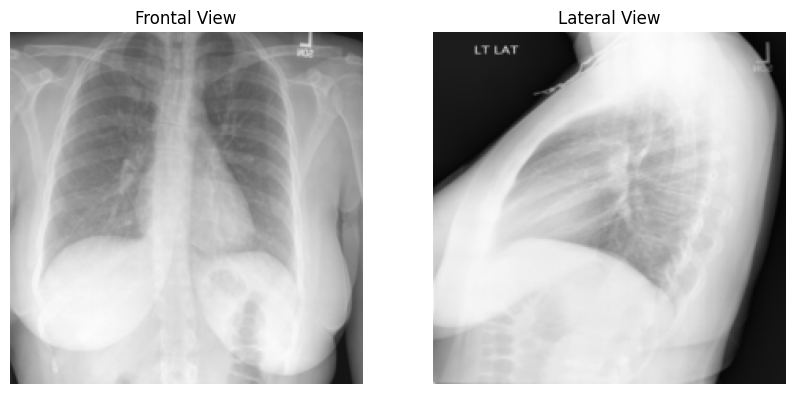

True Caption: The heart is normal in size and contour. There is no mediastinal widening. The lungs are clear bilaterally. No large pleural effusion or pneumothorax. Mild dextro curvature of the thoracic spine, possibly positional.
Predicted Caption:  XXXX and lateral chest examination was obtained. The heart silhouette is normal in size and contour. There is no mediastinal widening. There is
--------------------------------------------------


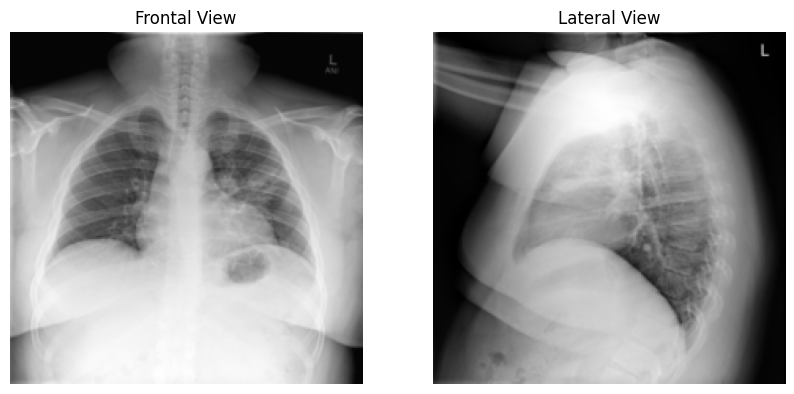

True Caption: The heart, pulmonary XXXX and mediastinum are within normal limits. There is no pleural effusion or pneumothorax. There is a region of left upper lobe perihilar opacity identified.
Predicted Caption:  and lateral views of the chest. There is aortic XXXX and soft tissues are normal. There is no pneumothorax. There is
--------------------------------------------------


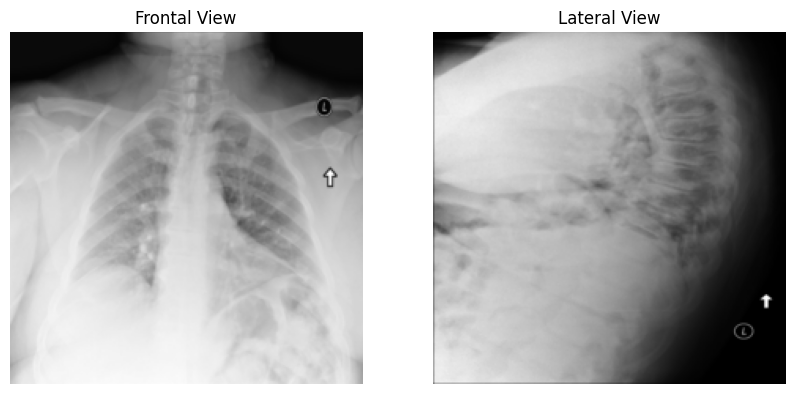

True Caption: nan
Predicted Caption: . No pleural effusions. No pneumothorax. Heart size within normal limits.
--------------------------------------------------


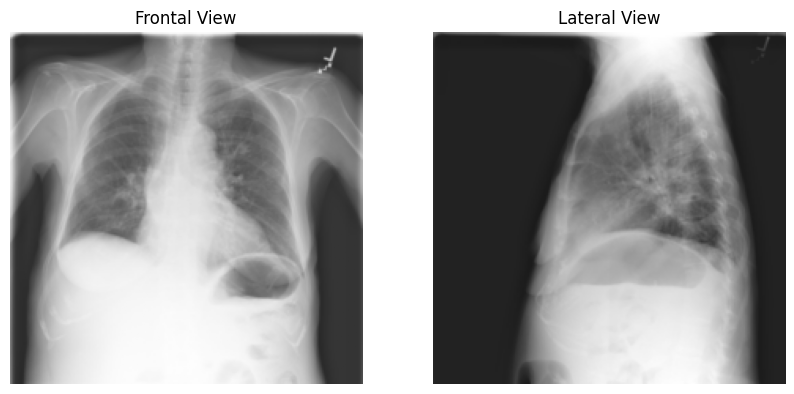

True Caption: No evidence of airspace opacity. No effusion or noncalcified nodules. No evidence of pneumothorax. Normal heart size and mediastinum. Visualized XXXX of the chest are within normal limits.
Predicted Caption:  and lateral views of the chest. The cardiomediastinal silhouette is normal. No pneumothorax or pleural effusion. No
--------------------------------------------------


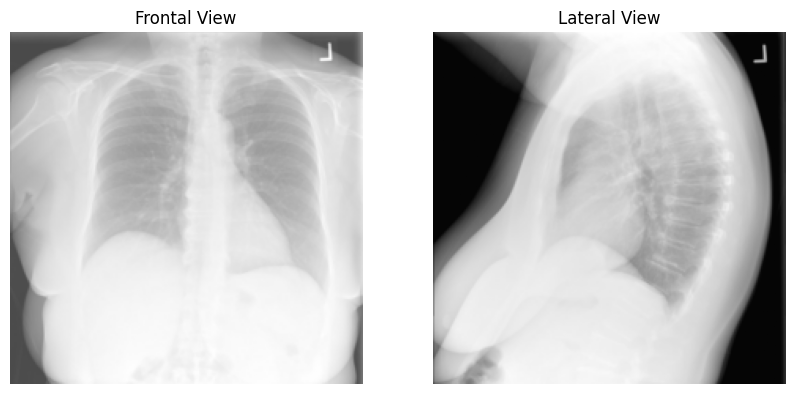

True Caption: Heart size and mediastinal contours are within normal limits. Pulmonary vasculature is unremarkable. No focal airspace consolidation. There is mild elevation right hemidiaphragm. No visible pleural effusion or pneumothorax. There are mild degenerative changes along the thoracic spine.
Predicted Caption:  and lateral views the chest XXXX are normal. There is no pleural effusion or pneumothorax. There is no focal air space opacity
--------------------------------------------------


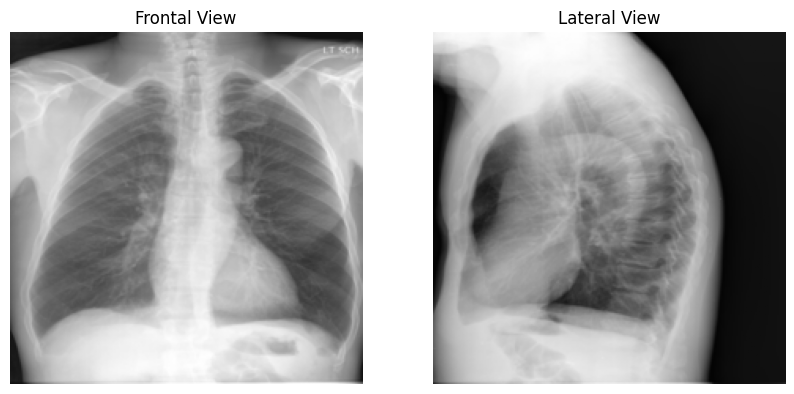

True Caption: The lungs remain hyperexpanded. No masses or infiltrates in the lungs. No pleural or mediastinal air collections. Heart size normal.
Predicted Caption:  XXXX XXXX and lateral chest examination was obtained. The heart is normal in size and contour. There is aortic XXXX are normal
--------------------------------------------------


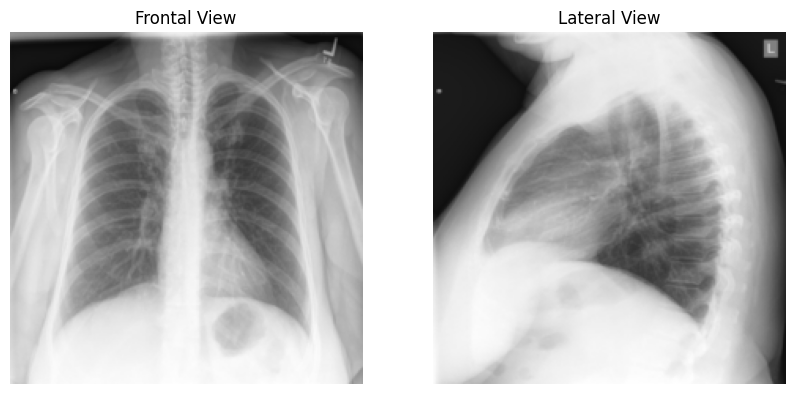

True Caption: The heart size and pulmonary vascularity appear within normal limits. The lungs are free of focal airspace disease. No pleural effusion or pneumothorax is seen.
Predicted Caption:  of the right XXXX and lateral views of the chest. The cardiomediastinal contours are within normal limits. No focal consolidation,
--------------------------------------------------


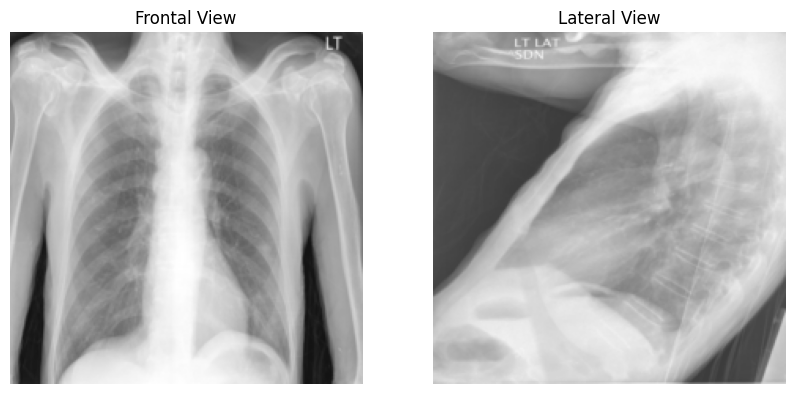

True Caption: nan
Predicted Caption:  XXXX and lateral views of the chest XXXX. The cardiomediastinal silhouette is within normal limits. No pleural effusion is
--------------------------------------------------


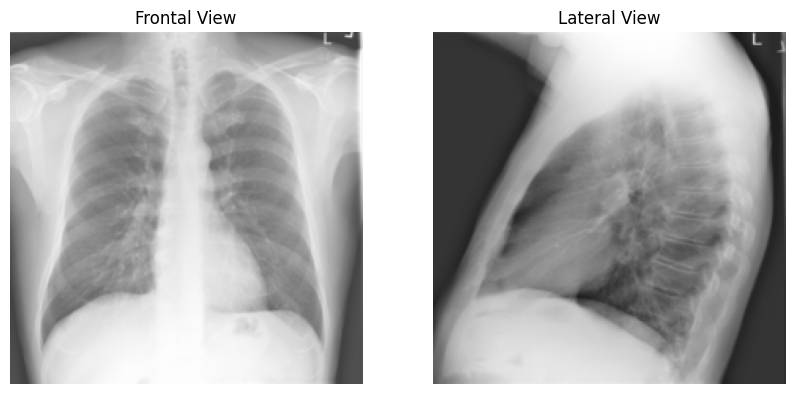

True Caption: The heart and mediastinal silhouettes are within normal limits. The lungs are clear without focal airspace opacity, large effusion, or pneumothorax. The XXXX are grossly intact. Degenerative T-spine osteophytes.
Predicted Caption:  and lateral views of the chest XXXX XXXX and lateral views of the chest with no focal consolidation, pneumothorax, or pleural eff
--------------------------------------------------


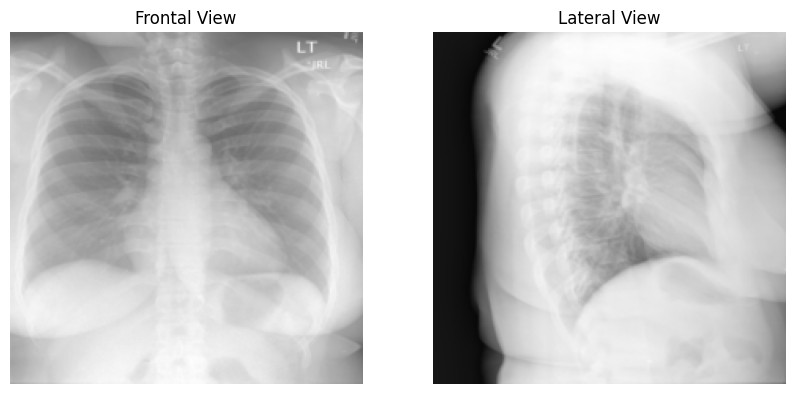

True Caption: The cardiomediastinal silhouette is within normal limits for size and contour. The lungs are normally inflated without evidence of focal airspace disease, pleural effusion, or pneumothorax. Osseous structures are within normal limits for patient age..
Predicted Caption:  XXXX and lateral views of the chest with no focal consolidation, pleural effusion, or pneumothorax. The heart size and pulmonary vascular
--------------------------------------------------


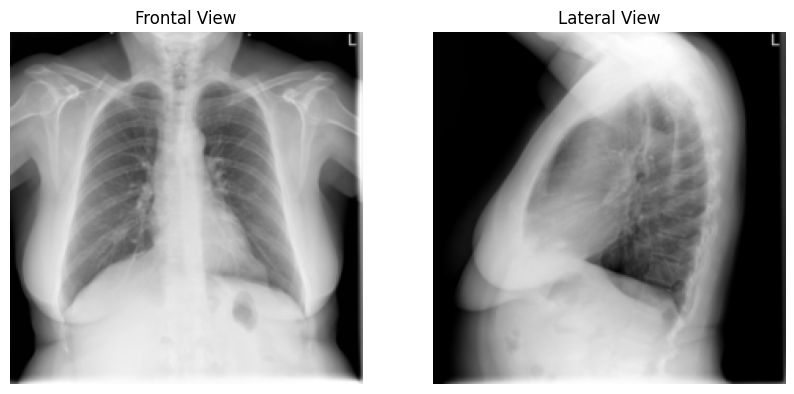

True Caption: The lungs appear clear. There are no suspicious pulmonary nodules or masses. The heart and pulmonary XXXX appear normal. Mediastinal contours appear normal. There's no pneumothorax.
Predicted Caption:  XXXX and lateral views of the chest XXXX. The cardiomediastinal silhouette is within normal limits. There is no pneumothor
--------------------------------------------------


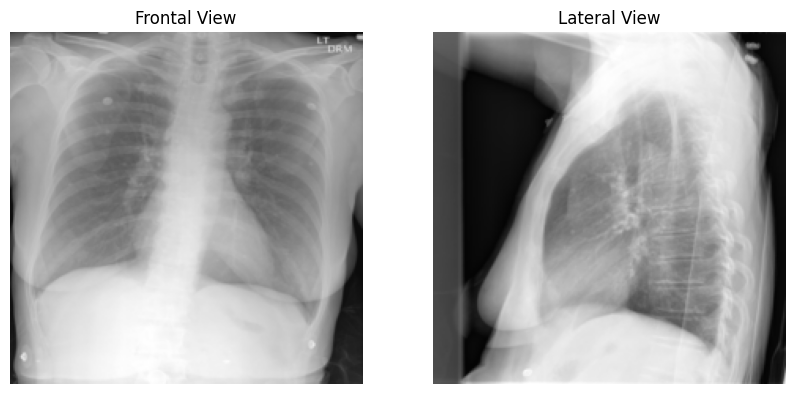

True Caption: Heart size and mediastinal contour within normal limits. Multiple calcified granulomas in the bilateral XXXX and lung parenchyma. No focal airspace consolidation, pneumothorax, or large pleural effusion. No acute osseous abnormality.
Predicted Caption:  of the lateral views. The cardiomediastinal silhouette is within normal limits. There are no pneumothorax, pleural effusion
--------------------------------------------------


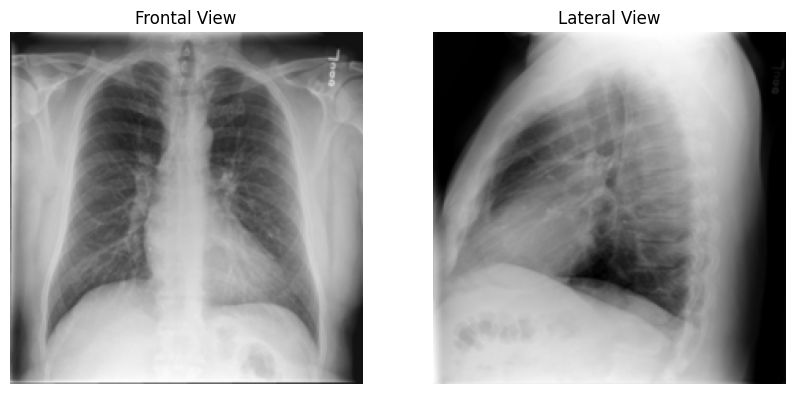

True Caption: The heart and mediastinum are normal in size and contour. There is no focal airspace opacity, pleural effusion, or pneumothorax. There are degenerative changes in the thoracic spine.
Predicted Caption:  and lateral views of the chest XXXX. The cardiomediastinal contours are normal. There is no pneumothorax or ple
--------------------------------------------------


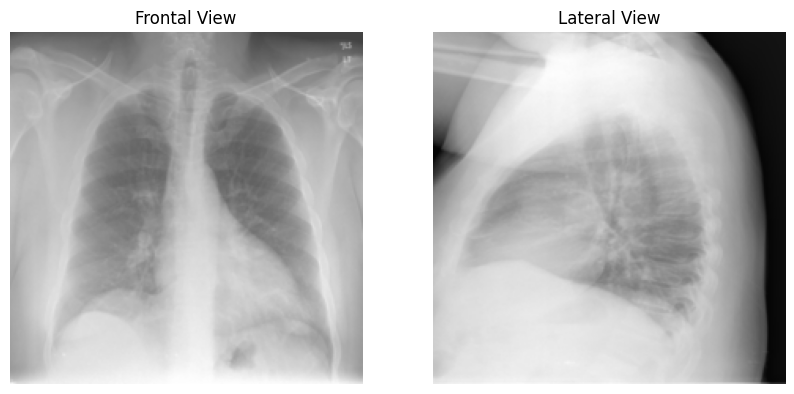

True Caption: Cardiac and mediastinal silhouettes are normal. Pulmonary vasculature is normal. No pneumothorax or pleural effusion. No acute bony abnormality. XXXX XXXX opacities XXXX reflecting atelectasis versus bronchovascular crowding.
Predicted Caption:  XXXX atelectasis. There is a pneumonia. There is no pneumothorax, pleural effusion or focal airspace consolidation. No acute
--------------------------------------------------


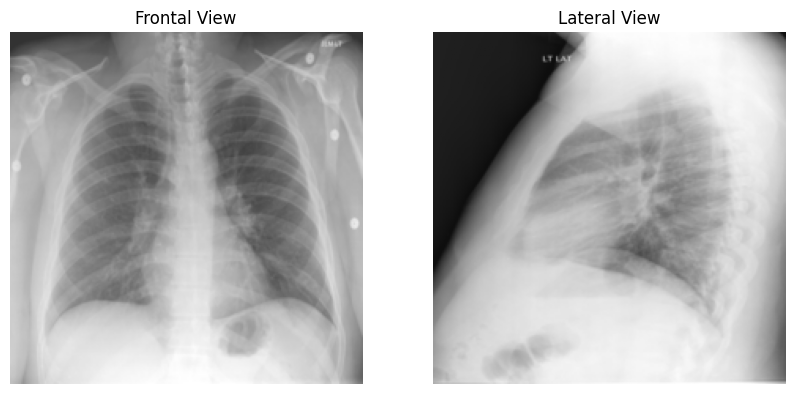

True Caption: The heart is normal in size. The mediastinum is stable. The lungs are clear.
Predicted Caption:  and lateral views of the chest XXXX, XXXX, XXXX, pleural effusion, or pneumothorax. The cardiomed
--------------------------------------------------


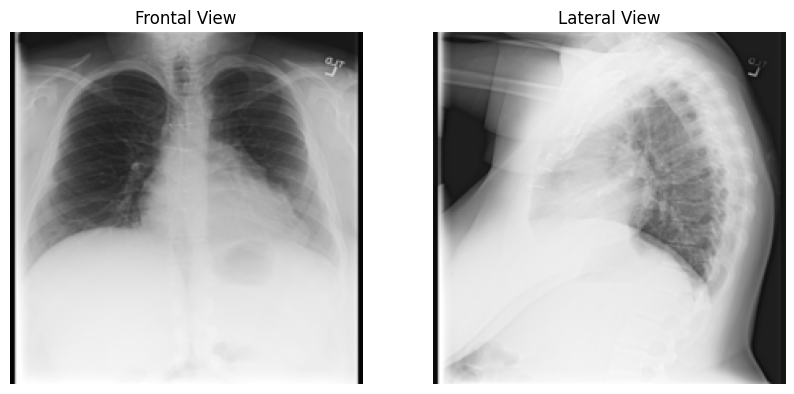

True Caption: The lungs are clear. There is no pleural effusion or pneumothorax. There has been XXXX XXXX sternotomy. The heart and mediastinum are normal. The skeletal structures are normal.
Predicted Caption:  of the right XXXX. No pleural effusion or pneumothorax. No acute bony abnormality.
--------------------------------------------------


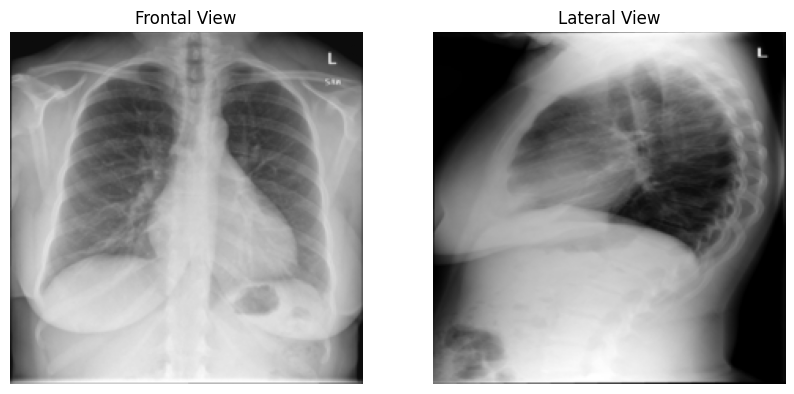

True Caption: The trachea is midline. The cardiomediastinal silhouette is normal. The lungs are clear, without evidence of acute infiltrate or effusion. There is no evidence of tuberculous disease. There is no pneumothorax. The visualized bony structures reveal no acute abnormalities.
Predicted Caption:  XXXX and lateral views of the chest XXXX. The cardiomediastinal silhouette is within normal limits. There is no pneumothor
--------------------------------------------------


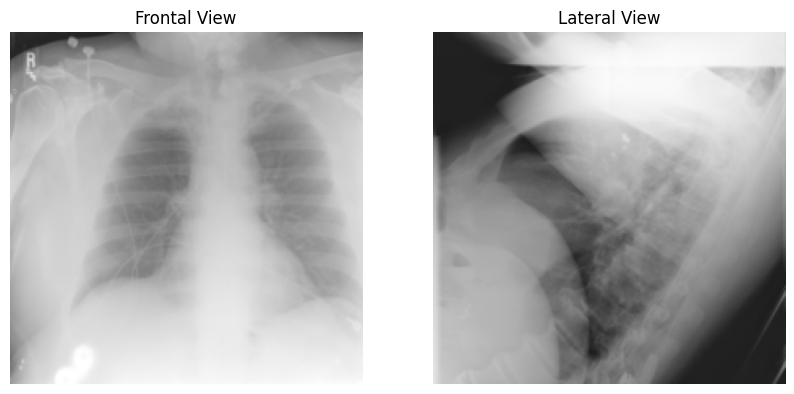

True Caption: There is a right chest XXXX with catheter tip at the cavoatrial junction. Heart size is at the upper limits of normal. Lungs are grossly clear. No pleural effusion or pneumothorax. There are diffuse degenerative changes of the spine.
Predicted Caption:  XXXX. No pneumothorax or pleural effusion.
--------------------------------------------------


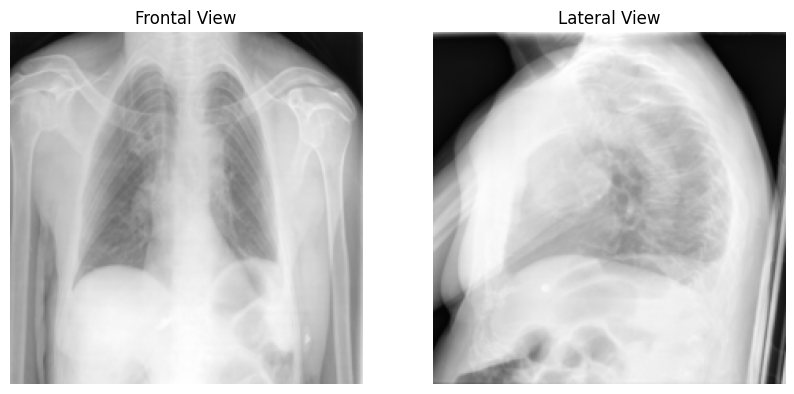

True Caption: Chest. Lung volumes are low, but no focal infiltrates are present. Heart and mediastinum remain normal. Abdomen. Multiple slightly distended loops are present from stomach to rectum. Formed stool is present in the rectum.
Predicted Caption:  of the right lung volumes. No focal consolidation, pneumothorax, or pleural effusion. Heart size is within normal limits. Heart size
--------------------------------------------------


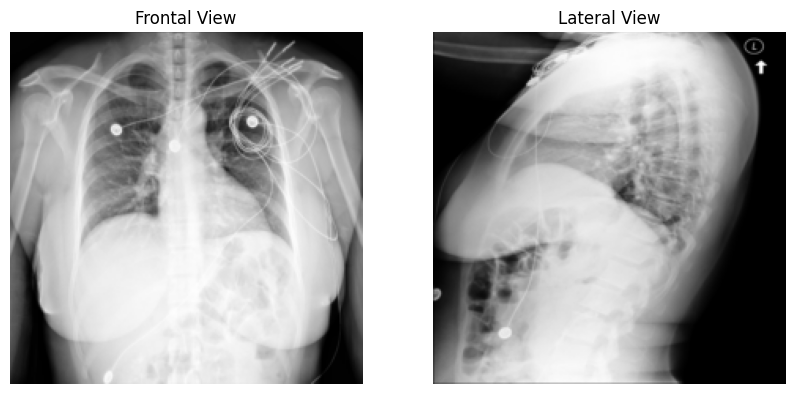

True Caption: There are lower lung volumes. There is central bronchovascular crowding. Volume loss in the medial right upper lobe seen on XXXX is not as well-demonstrated on radiography. No lobar consolidation. No pleural effusion or pneumothorax.
Predicted Caption:  XXXX and lateral views of the chest were obtained. The cardiomediastinal contours are normal. There is no pneumothorax
--------------------------------------------------


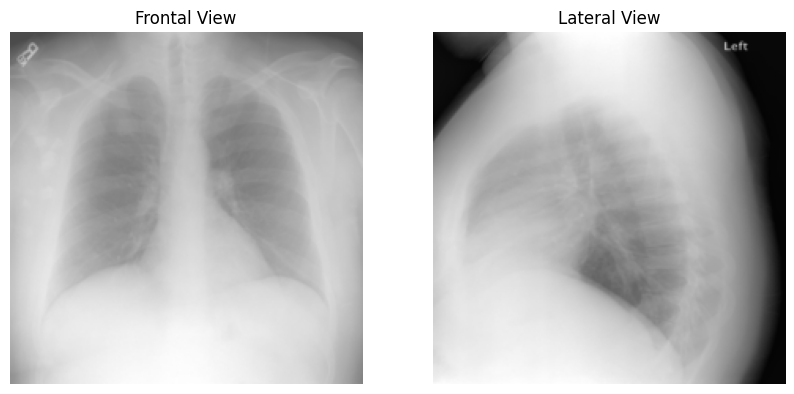

True Caption: The cardiac silhouette mediastinal contours are within normal limits. There are low lung volumes. There is no focal consolidation. There is pneumothorax. There is no large pleural effusion. There is prominent right anterior first rib end.
Predicted Caption:  XXXX and lateral views of the chest with aortic XXXX XXXX. The cardiomediastinal silhouette is normal. There is
--------------------------------------------------


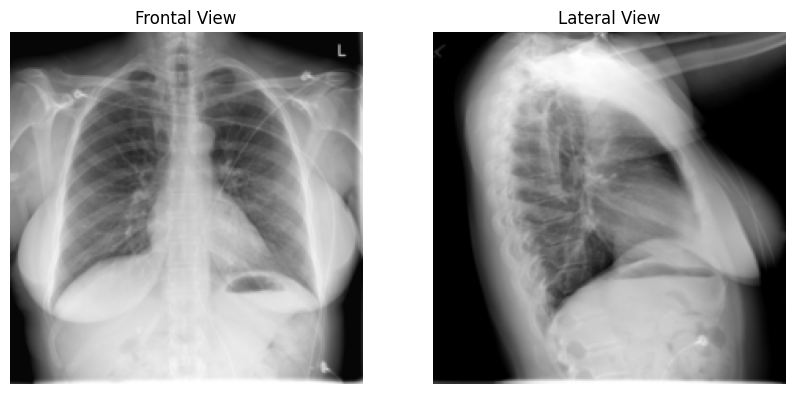

True Caption: Frontal and lateral views of the chest with overlying external cardiac monitor leads show normal size and configuration of the cardiac silhouette. Normal pulmonary vasculature and central airways. No focal airspace consolidation or pleural effusion. Incidental note XXXX of an azygos fissure. There are surgical clips, perhaps from cholecystectomy, in the right upper quadrant.
Predicted Caption:  appear within normal limits. No focal consolidation, pleural effusion, or pneumothorax is identified. No acute bony abnormality.
--------------------------------------------------


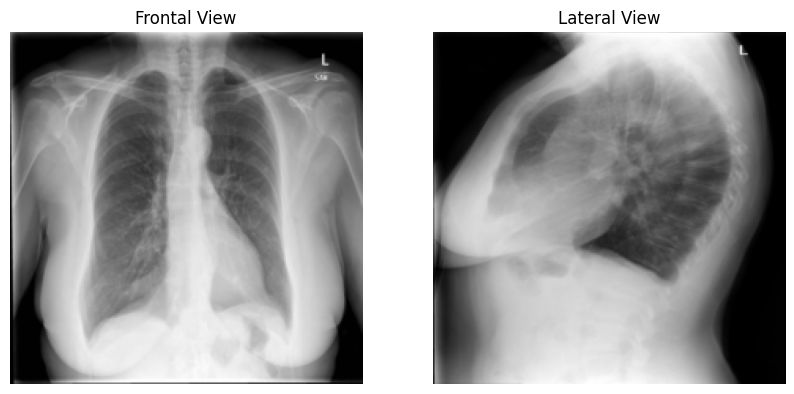

True Caption: Lungs are hyperexpanded. No infiltrates or masses in the lungs. Heart size normal.
Predicted Caption:  of the XXXX. There is no pleural effusion or pneumothorax.
--------------------------------------------------


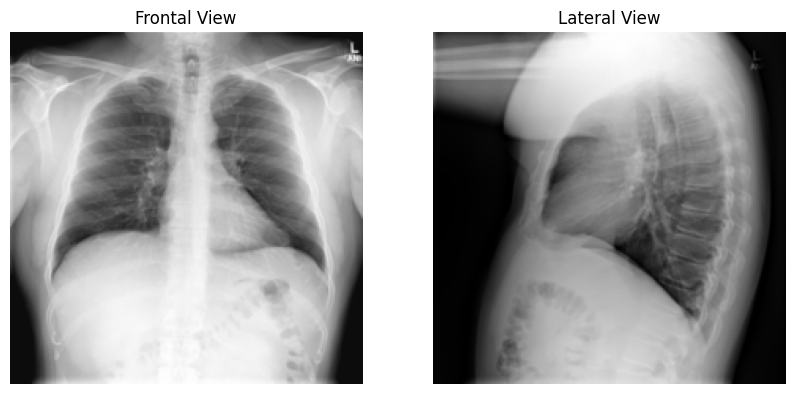

True Caption: The lungs are clear. No pleural effusion or pneumothorax is identified. The heart and mediastinum are normal. The skeletal structures and soft tissues are normal.
Predicted Caption:  XXXX. No pleural effusion or pneumothorax.
--------------------------------------------------


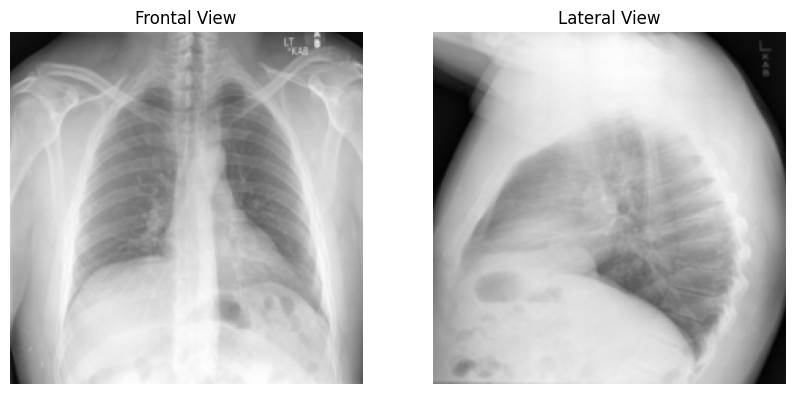

True Caption: The cardiomediastinal silhouette is within normal limits. The lungs are clear without areas of focal consolidation. No pneumothorax or pleural effusion. XXXX lucency under the right hemidiaphragm may represent a focus of free air.
Predicted Caption:  XXXX, mediastinum, and hilar contours are within normal limits. There is no pleural effusion or pneumothorax.
--------------------------------------------------


In [40]:
import torch
from tqdm import tqdm
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
# nltk.download('punkt')  # Se necessario per tokenizzare

def calculate_rouge_l(predicted_text, reference_text):
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    score = scorer.score(reference_text, predicted_text)
    return score['rougeL'].fmeasure

def test(model, test_loader, tokenizer):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()

    # Contatori separati per BLEU-1, BLEU-2, BLEU-3, BLEU-4 e ROUGE-L
    total_bleu1_score = 0.0
    total_bleu2_score = 0.0
    total_bleu3_score = 0.0
    total_bleu4_score = 0.0
    total_rouge_l_score_caption = 0.0
    
    smoothie = SmoothingFunction().method1  # Per smoothing dei BLEU

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            # Spostiamo i tensori su GPU/CPU
            front_img = batch['front_pixel_values'].to(device)
            lateral_img = batch['lateral_pixel_values'].to(device)
            input_ids_problem = batch['input_ids_problem'].to(device)
            attention_mask_problem = batch['attention_mask_problem'].to(device)

            # Generiamo le caption
            gen_output = model.generate(
                front_image=front_img,
                lateral_image=lateral_img,
                input_ids_problem=input_ids_problem,
                attention_mask_problem=attention_mask_problem,
                max_length=30,
                sos_token_id=tokenizer.bos_token_id if tokenizer.bos_token_id is not None else tokenizer.eos_token_id,
                eos_token_id=tokenizer.eos_token_id,
                top_k=20, 
                top_p=0.8,
                temperature=0.7
            )


            # Estraggo le caption generate (token IDs)
            predicted_ids_caption = gen_output['generated_tokens']  # [B, seq_len]

            # Confronto predizioni con le caption di riferimento
            for pred_caption_ids, ref_caption_ids in zip(predicted_ids_caption, batch['input_ids_caption']):
                # Decodifica in stringhe
                pred_caption_text = tokenizer.decode(pred_caption_ids.cpu().tolist(), skip_special_tokens=True)
                ref_caption_text = tokenizer.decode(ref_caption_ids.cpu().tolist(), skip_special_tokens=True)

                # Tokenizzazione semplice (se preferisci puoi usare tokenizer.tokenize)
                pred_tokens = nltk.word_tokenize(pred_caption_text)
                ref_tokens = nltk.word_tokenize(ref_caption_text)

                # Calcoliamo BLEU-1, BLEU-2, BLEU-3, BLEU-4
                # Usando pesi diversi per ciascun n-gram
                #  - BLEU-1:   (1, 0, 0, 0)
                #  - BLEU-2:   (0.5, 0.5, 0, 0)
                #  - BLEU-3:   (0.33, 0.33, 0.33, 0)
                #  - BLEU-4:   (0.25, 0.25, 0.25, 0.25)
                reference_list = [ref_tokens]  # BLEU accetta lista di liste per riferimenti
                bleu1 = sentence_bleu(
                    reference_list, 
                    pred_tokens, 
                    weights=(1, 0, 0, 0),
                    smoothing_function=smoothie
                )
                bleu2 = sentence_bleu(
                    reference_list, 
                    pred_tokens, 
                    weights=(0.5, 0.5, 0, 0),
                    smoothing_function=smoothie
                )
                bleu3 = sentence_bleu(
                    reference_list, 
                    pred_tokens, 
                    weights=(0.33, 0.33, 0.34, 0),
                    smoothing_function=smoothie
                )
                bleu4 = sentence_bleu(
                    reference_list, 
                    pred_tokens, 
                    weights=(0.25, 0.25, 0.25, 0.25),
                    smoothing_function=smoothie
                )

                total_bleu1_score += bleu1
                total_bleu2_score += bleu2
                total_bleu3_score += bleu3
                total_bleu4_score += bleu4

                # (B) ROUGE-L
                rouge_l_score_caption = calculate_rouge_l(pred_caption_text, ref_caption_text)
                total_rouge_l_score_caption += rouge_l_score_caption

    # Calcolo medie finali
    dataset_size = len(test_loader.dataset)
    metrics = {
        'BLEU-1': total_bleu1_score / dataset_size,
        'BLEU-2': total_bleu2_score / dataset_size,
        'BLEU-3': total_bleu3_score / dataset_size,
        'BLEU-4': total_bleu4_score / dataset_size,
        'ROUGE-L': total_rouge_l_score_caption / dataset_size
    }

    print("\nTest Results:")
    print(f"BLEU-1:   {metrics['BLEU-1']:.4f}")
    print(f"BLEU-2:   {metrics['BLEU-2']:.4f}")
    print(f"BLEU-3:   {metrics['BLEU-3']:.4f}")
    print(f"BLEU-4:   {metrics['BLEU-4']:.4f}")
    print(f"ROUGE-L:  {metrics['ROUGE-L']:.4f}")

    return metrics


def visualize_predictions(model, test_loader, tokenizer, num_images=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    visualizations_shown = 0

    with torch.no_grad():
        for batch in test_loader:
            # Spostiamo i tensori su GPU/CPU
            front_img = batch['front_pixel_values'].to(device)
            lateral_img = batch['lateral_pixel_values'].to(device)
            input_ids_problem = batch['input_ids_problem'].to(device)
            attention_mask_problem = batch['attention_mask_problem'].to(device)

            # Generiamo le caption
            gen_output = model.generate(
                front_image=front_img,
                lateral_image=lateral_img,
                input_ids_problem=input_ids_problem,
                attention_mask_problem=attention_mask_problem,
                max_length=30,
                sos_token_id=tokenizer.bos_token_id if tokenizer.bos_token_id is not None else tokenizer.eos_token_id,
                eos_token_id=tokenizer.eos_token_id,
                top_k=15, 
                top_p=0.8,
                temperature=0.7
            )

            predicted_ids_caption = gen_output['generated_tokens']

            for i in range(len(predicted_ids_caption)):
                if visualizations_shown >= num_images:
                    return

                # Decodifichiamo la caption generata
                pred_caption = tokenizer.decode(predicted_ids_caption[i].cpu().tolist(),
                                                skip_special_tokens=True)
                # Decodifichiamo la caption vera di riferimento
                true_caption = tokenizer.decode(batch['input_ids_caption'][i].cpu().tolist(),
                                                skip_special_tokens=True)

                # Visualizzazione
                plt.figure(figsize=(10, 5))

                # Frontal
                plt.subplot(1, 2, 1)
                front_img_cpu = batch['front_pixel_values'][i].cpu()
                plt.imshow(front_img_cpu.permute(1, 2, 0))
                plt.axis('off')
                plt.title('Frontal View')

                # Lateral
                plt.subplot(1, 2, 2)
                lateral_img_cpu = batch['lateral_pixel_values'][i].cpu()
                plt.imshow(lateral_img_cpu.permute(1, 2, 0))
                plt.axis('off')
                plt.title('Lateral View')

                plt.show()

                print(f"True Caption: {true_caption}")
                print(f"Predicted Caption: {pred_caption}")
                print('-' * 50)

                visualizations_shown += 1

# Esempio di chiamate (assumendo model, test_loader, tokenizer già definiti)
metrics = test(model, test_loader, tokenizer)
visualize_predictions(model, test_loader, tokenizer, num_images=25)

Accuracy su tutto il set di validazione: 95.62%

Accuratezze relative per classe:
Classe 0: 97.18% (345/355)
Classe 1: 98.21% (330/336)
Classe 2: 78.95% (75/95)
Classe 3: 96.55% (168/174)


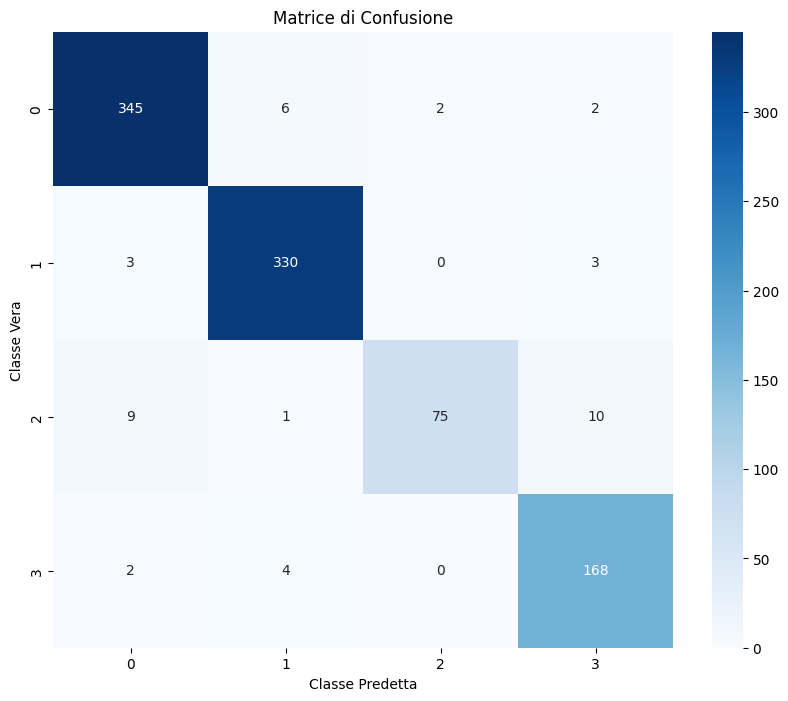


Dettagli predizioni:
Campione 1: Classe vera = 3, Classe predetta = 3
Campione 2: Classe vera = 1, Classe predetta = 1
Campione 3: Classe vera = 1, Classe predetta = 1
Campione 4: Classe vera = 0, Classe predetta = 0
Campione 5: Classe vera = 3, Classe predetta = 3
Campione 6: Classe vera = 1, Classe predetta = 1
Campione 7: Classe vera = 0, Classe predetta = 0
Campione 8: Classe vera = 0, Classe predetta = 0
Campione 9: Classe vera = 3, Classe predetta = 3
Campione 10: Classe vera = 0, Classe predetta = 0
Campione 11: Classe vera = 0, Classe predetta = 0
Campione 12: Classe vera = 1, Classe predetta = 1
Campione 13: Classe vera = 3, Classe predetta = 3
Campione 14: Classe vera = 1, Classe predetta = 1
Campione 15: Classe vera = 0, Classe predetta = 0
Campione 16: Classe vera = 0, Classe predetta = 0
Campione 17: Classe vera = 0, Classe predetta = 0
Campione 18: Classe vera = 3, Classe predetta = 3
Campione 19: Classe vera = 1, Classe predetta = 1
Campione 20: Classe vera = 1, Classe 

In [41]:
def evaluate_predictions_full(model, val_loader, num_class_pred):
    import torch
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    correct_predictions = 0
    total_predictions = 0
    class_correct = torch.zeros(num_class_pred, dtype=torch.int32)
    class_total = torch.zeros(num_class_pred, dtype=torch.int32)
    all_predictions = []
    true_labels = []
    pred_labels = []
    
    with torch.no_grad():
        for batch in val_loader:
            # Recupera input e label
            front_image = batch['front_pixel_values']
            lateral_image = batch['lateral_pixel_values']
            labels = batch['classification_label']
            
            # Forward
            outputs = model(
                front_image=front_image,
                lateral_image=lateral_image,
                input_ids_caption=batch['input_ids_caption'],
                input_ids_problem=batch['input_ids_problem'],
                attention_mask_problem=batch['attention_mask_problem']
            )
            logits = outputs["classification_logits"]
            predicted_labels = torch.argmax(logits, dim=1)
            
            # Salva predizioni e vere etichette
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(predicted_labels.cpu().numpy())
            
            for true_label, pred_label in zip(labels.tolist(), predicted_labels.tolist()):
                all_predictions.append((true_label, pred_label))
                
            # Accuratezza globale
            correct_predictions += (predicted_labels == labels).sum().item()
            total_predictions += labels.size(0)
            
            # Accuratezza di classe
            for class_label in range(num_class_pred):
                class_correct[class_label] += ((predicted_labels == class_label) &
                                           (labels == class_label)).sum().item()
                class_total[class_label] += (labels == class_label).sum().item()
    
    # Accuratezza globale
    accuracy = 100.0 * correct_predictions / total_predictions
    print(f"Accuracy su tutto il set di validazione: {accuracy:.2f}%")
    
    # Accuratezza per classe
    print("\nAccuratezze relative per classe:")
    for class_label in range(num_class_pred):
        if class_total[class_label] > 0:
            class_accuracy = 100.0 * class_correct[class_label] / class_total[class_label]
            print(f"Classe {class_label}: {class_accuracy:.2f}% "
                  f"({class_correct[class_label]}/{class_total[class_label]})")
        else:
            print(f"Classe {class_label}: Nessun campione presente.")
    
    # Calcola e visualizza la matrice di confusione
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Matrice di Confusione')
    plt.ylabel('Classe Vera')
    plt.xlabel('Classe Predetta')
    plt.show()
    
    # Stampa tutte le predizioni
    print("\nDettagli predizioni:")
    for i, (true_label, pred_label) in enumerate(all_predictions):
        print(f"Campione {i + 1}: Classe vera = {true_label}, Classe predetta = {pred_label}")

    return accuracy, cm

accuracy, confusion_matrix = evaluate_predictions_full(model, test_loader)

In [42]:
import os
import torch

# Definisco la directory di salvataggio
save_directory = "./saved_model"
os.makedirs(save_directory, exist_ok=True)

# Save the model state dictionary
#model.state_dict() Contiene i parametri del modello (pesi e bias), che rappresentano lo stato appreso durante l'addestramento.
torch.save(model.state_dict(), os.path.join(save_directory, "model.pth"))

# Save the tokenizer
tokenizer.save_pretrained(save_directory)

print(f"Model and tokenizer saved to {save_directory}")

Model and tokenizer saved to ./saved_model
